### Problem 2:


$$
\begin{cases}
-\Delta u = 1 &\text{on } \Omega\\
u = 0 &\text{on } \partial\Omega
\end{cases}
\label{eqn:problem2}
$$
where $\Omega = (-1,1)\times(-1,1)\setminus[0,1)\times\{0\}$. 
##### In this implementation, we use the exact boundary method.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cbook as cbook
import matplotlib.patches as patches
from ipywidgets import IntProgress
from IPython.display import display
import time

--------------------------------------------------------------------------------------------------------------------------------

# Architectures

## Shallow NN, Tanh Activation

In [6]:
class srnn_Tanh(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.input(x))
        x = self.tanh(self.hidden(x))
        x = self.output(x)
        return x

## Shallow NN, ReLU Activation

In [7]:
class srnn_ReLU(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

## Feedforward NN, tanh Activation

In [8]:
class drfnn_Tanh(nn.Module):
    """
    drfnn2 -- Deep Ritz Feedforward Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.phi = nn.Tanh()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.phi(self.stack[i](x))
        x = self.output(x)
        return x

## Feedforward NN, ReLU Activation

In [9]:
class drfnn_ReLU(nn.Module):
    """
    drnn -- Deep Ritz Feedforward Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.relu(self.stack[i](x))
        x = self.output(x)
        return x

## Original Residual NN, Tanh Activation

In [10]:
class Block(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.Tanh()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [11]:
class drrnn_Tanh(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4):
        super(drrnn_Tanh, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

## Original Residual NN, ReLU Activation

In [12]:
class BlockReLU(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N):
        super(BlockReLU, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.ReLU()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [13]:
class drrnn_ReLU(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4):
        super(drrnn_ReLU, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        #self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(BlockReLU(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

--------------------------------------------------------------------------------------------------------------------------------

# Sampling in $\mathbb{R}^2$

In [14]:
# ORIGINAL DOMAIN: \Omega = (-1,1)^2 \ [0,1)x{0}
def get_interior_points_original(N=180,d=2):
    """
    randomly sample N points from interior of (-1,1)^2 \ [0,1)x{0}
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points_original(N=32):
    """
    randomly sample N points from boundary of (-1,1)^2 \ [0,1)x{0}
    """
    index = torch.rand(N,1)
    index1 = torch.rand(N,1) * 2 - 1
    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1)
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)

    return xb

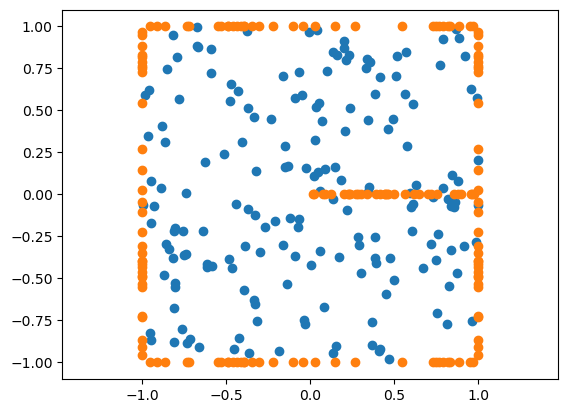

In [15]:
X = get_interior_points_original()
Y = get_boundary_points_original()
plt.scatter(X[:,0],X[:,1])
plt.scatter(Y[:,0],Y[:,1])
plt.axis('equal')
plt.show()

In [16]:
# SWITCHBOARD FOR DOMAINS
def get_points(domain='exact_original', density=128):
    """
    Switchboard for domains
    """
    xr = get_interior_points_original()
    xb = get_boundary_points_original()
        
    return xr, xb

In [17]:
def distfunc(xr):
    
    #mat = torch.cat((torch.abs(xr[:,0] - 1), torch.abs(xr[:,0] + 1), 
    #                 torch.abs(xr[:,1] - 1), torch.abs(xr[:,1] + 1), 
    #                 ((xr[:,0]>=0)*torch.abs(xr[:,1]) + (xr[:,0]<0)*torch.sqrt(torch.pow(xr[:,0], 2) + torch.pow(xr[:,0], 2)))), 
    #                 dim=1)

    x1 = torch.abs(xr[:,0] - 1).reshape((-1,1))
    x2 = torch.abs(xr[:,0] + 1).reshape((-1,1))
    x3 = torch.abs(xr[:,1] - 1).reshape((-1,1))
    x4 = torch.abs(xr[:,1] + 1).reshape((-1,1))
    x5 = ((xr[:,0]>=0)*torch.abs(xr[:,1]) + (xr[:,0]<0)*torch.sqrt(torch.pow(xr[:,0], 2) + torch.pow(xr[:,1], 2))).reshape((-1,1))
    
    mat = torch.cat((x1,x2, x3, x4, x5), dim=1)
          
    out = mat.min(dim=1).values
    return out

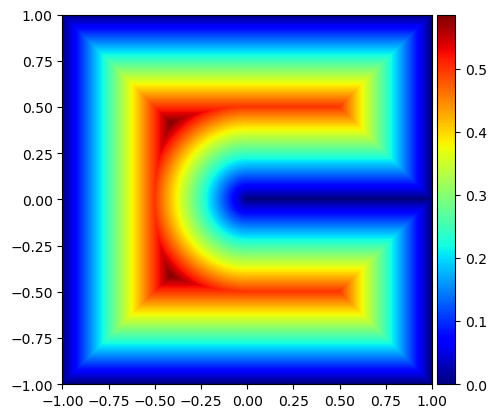

torch.Size([10000, 2])
torch.Size([10000, 1])


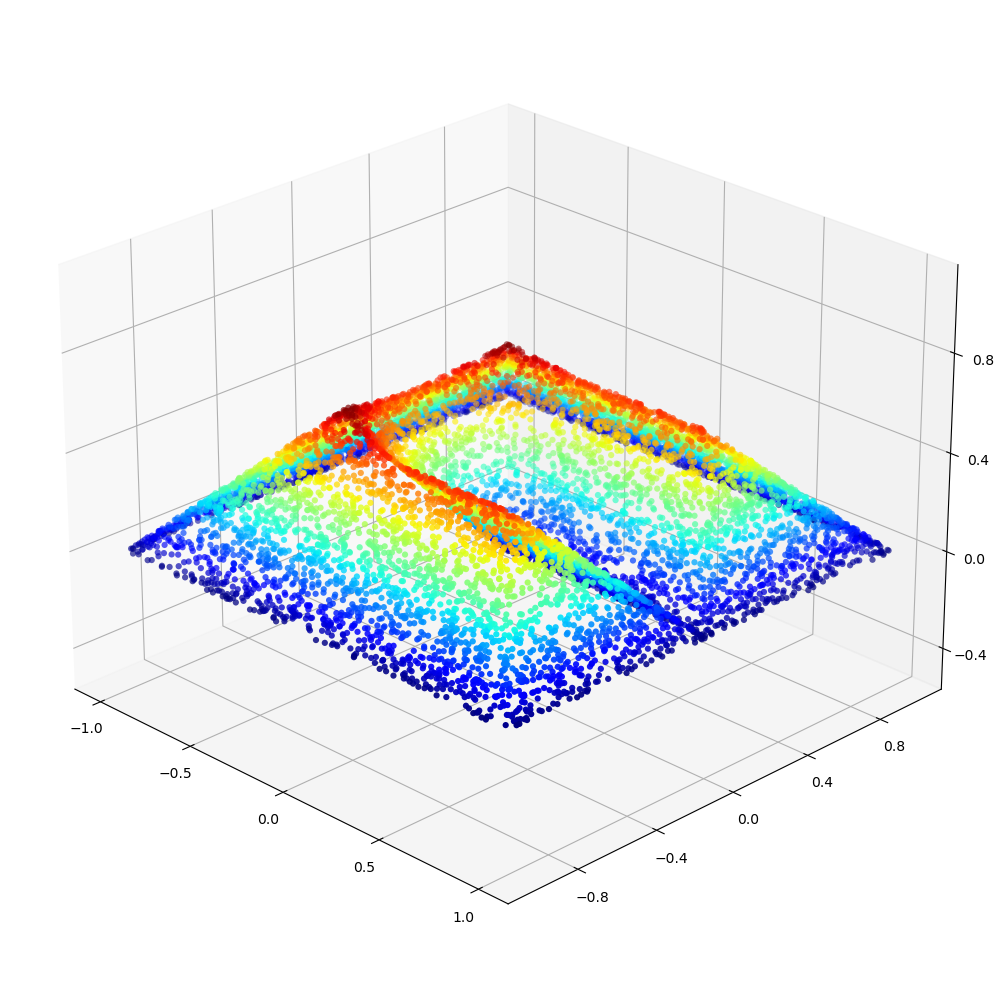

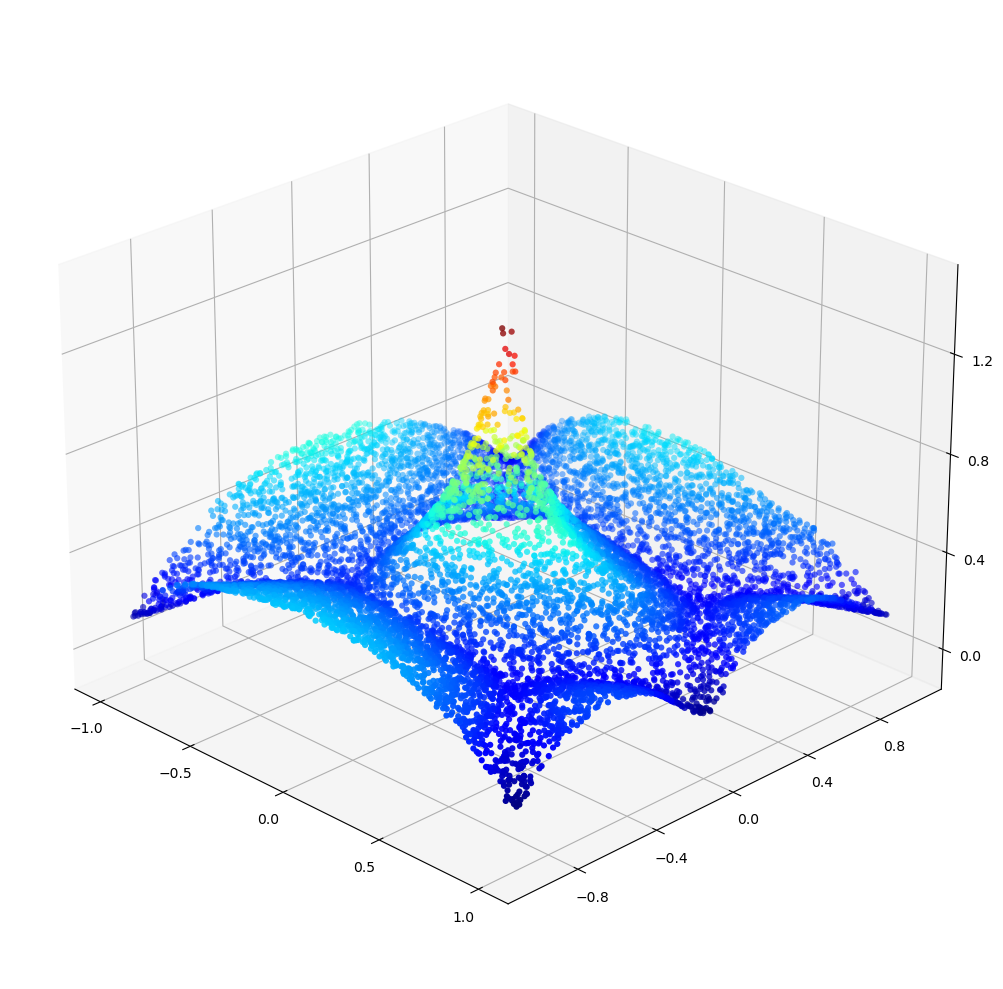

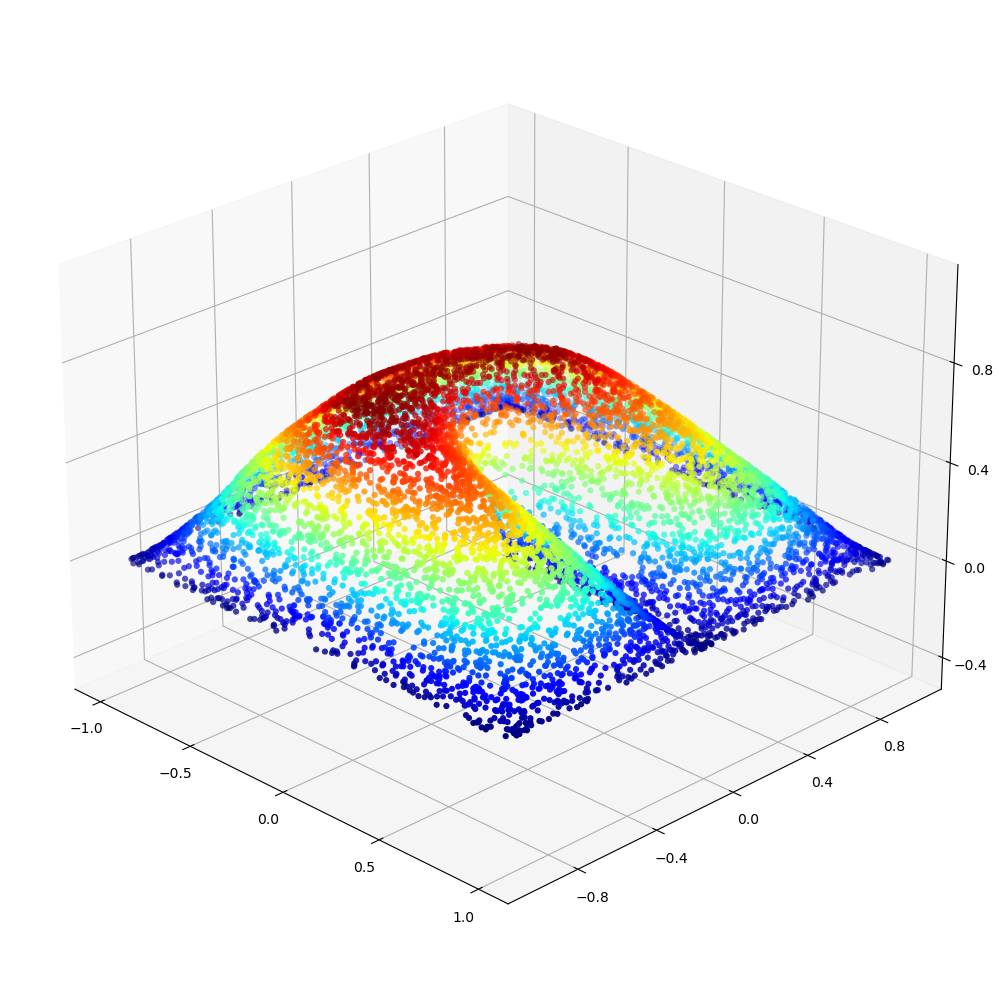

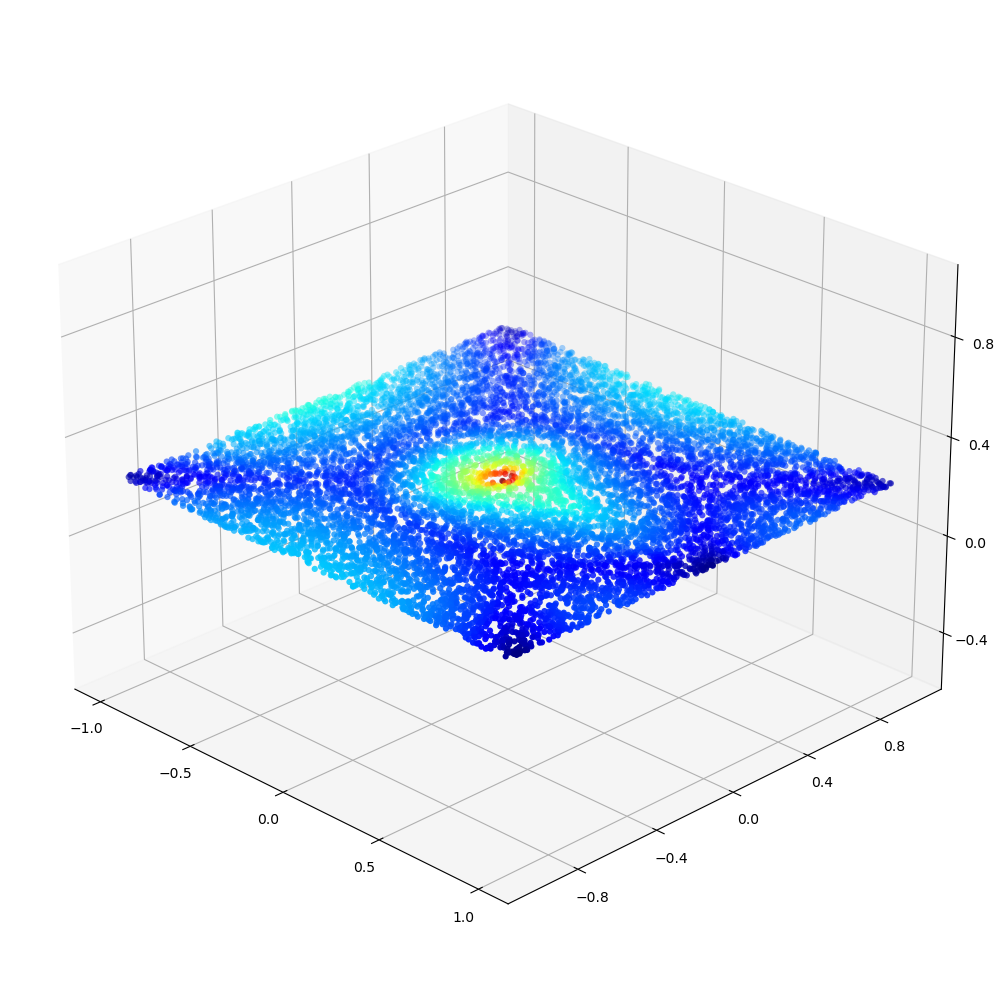

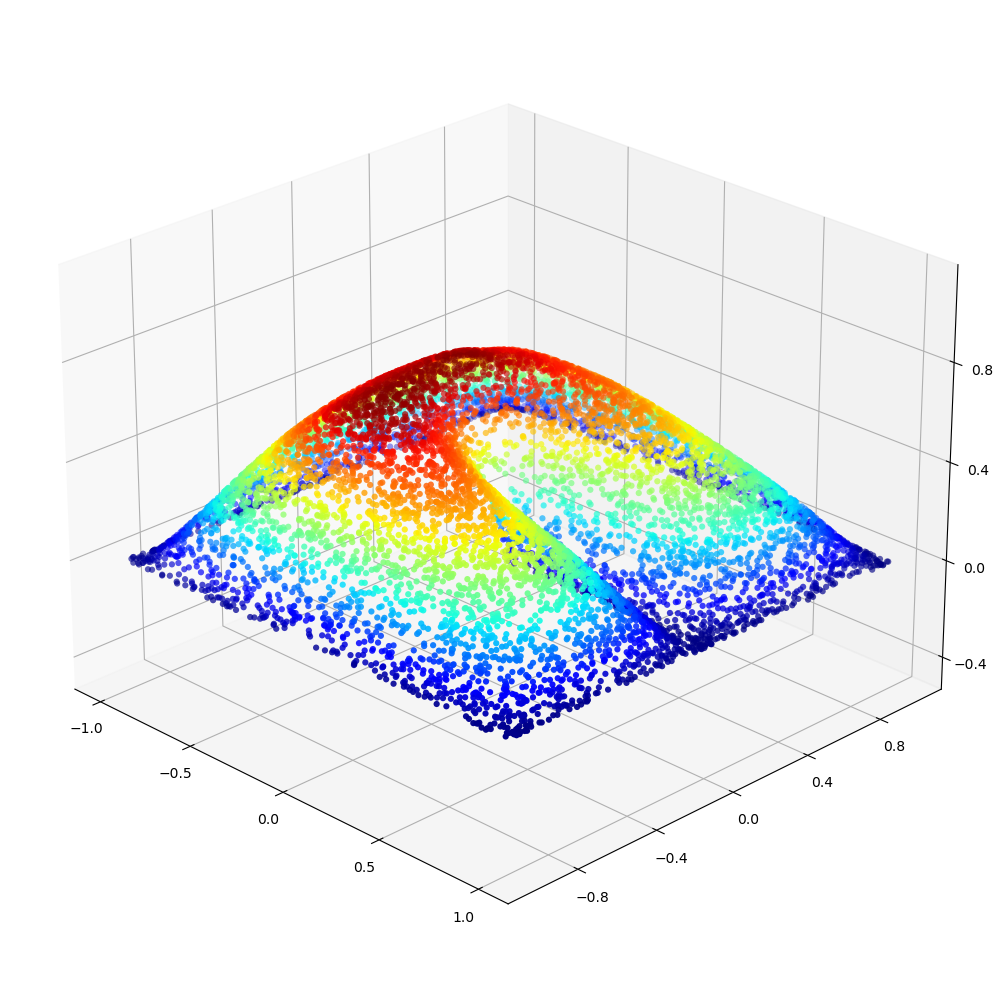

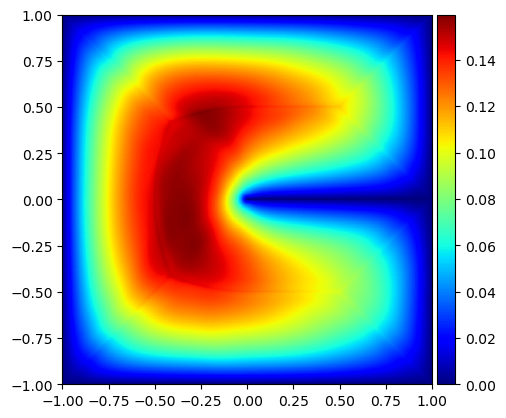

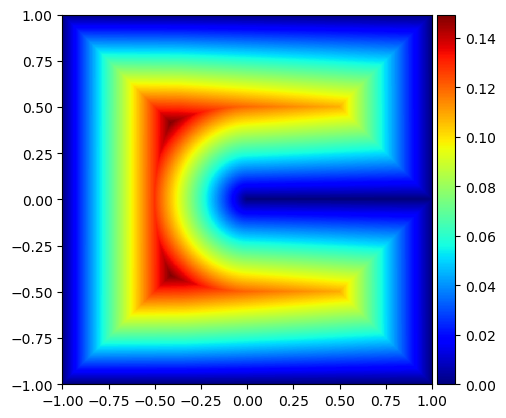

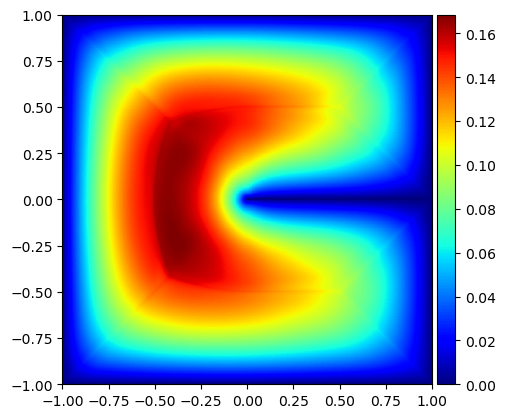

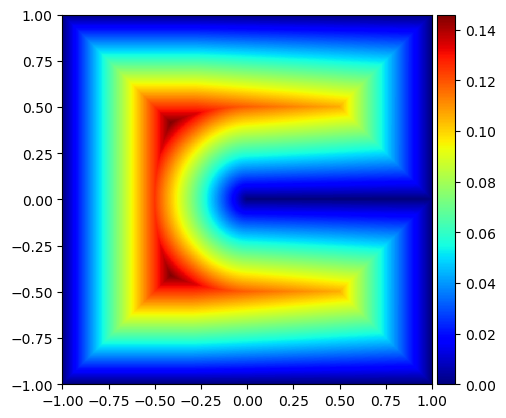

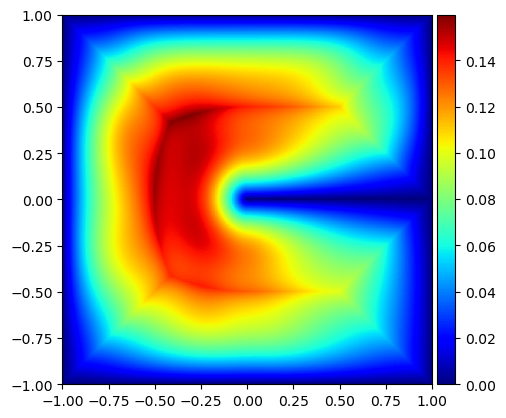

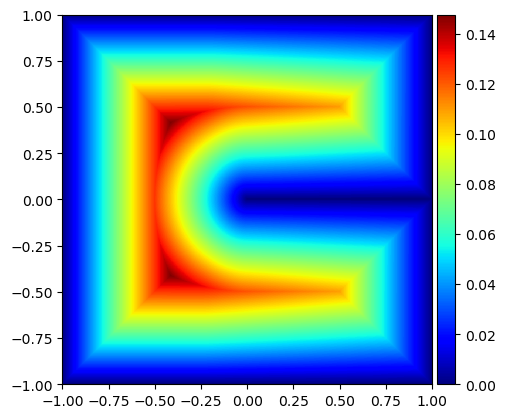

In [23]:
# 3D PLOT 
import numpy as np
import torch

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import figure

from numpy.random import randn
from scipy import array, newaxis
from random import randint





num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
#Z = Z.to(device)
#with torch.no_grad():
#    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred2
#pred = pred.cpu().numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
#if save == 1:
plt.savefig('exact_solutions/distance_function_original.png')
plt.show()



X = get_interior_points_original(10000)
Z = distfunc(X).reshape((-1,1))

print(X.shape)
print(Z.shape)

fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf2 = ax.scatter(X[:,0], X[:,1], Z, cmap='jet', linewidth=0, c=Z)

ax.view_init(azim=-45, elev=25)
#ax.view_init(azim=0, elev=0)
#ax.view_init(azim=270, elev=90)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.axis('equal')
#plt.savefig('pointwise_plots/L_shape.png')
plt.savefig('pointwise_plots/exact_original_distfunc.png')
plt.show()





device = torch.device('cpu')
model = drrnn_Tanh(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_drrnn_Tanh60000.mdl'))
with torch.no_grad():
    D = model(X)
D = D.cpu().numpy() 

fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf2 = ax.scatter(X[:,0], X[:,1], D, cmap='jet', linewidth=0, c=D)

ax.view_init(azim=-45, elev=25)
#ax.view_init(azim=270, elev=90)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.axis('equal')
plt.savefig('pointwise_plots/exact_original_network.png')
plt.show()


fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf2 = ax.scatter(X[:,0], X[:,1], 4*D*Z.numpy(), cmap='jet', linewidth=0, c=4*D*Z.numpy())

ax.view_init(azim=-45, elev=25)
#ax.view_init(azim=270, elev=90)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.axis('equal')
plt.savefig('pointwise_plots/exact_original_approx1.png')
plt.show()



device = torch.device('cpu')
model = drrnn_Tanh(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_drrnn_ReLU60000.mdl'))
with torch.no_grad():
    H = model(X)
H = H.cpu().numpy() 

fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf2 = ax.scatter(X[:,0], X[:,1], H, cmap='jet', linewidth=0, c=D)

ax.view_init(azim=-45, elev=25)
#ax.view_init(azim=270, elev=90)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.axis('equal')
plt.savefig('pointwise_plots/exact_original_network_ReLU2.png')
plt.show()


device = torch.device('cpu')
model = drrnn_Tanh(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_original_drrnn_Tanh30000.mdl'))
with torch.no_grad():
    D = model(X)
D = D.cpu().numpy() 


fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.add_subplot(1, 1, 1, projection='3d')

surf2 = ax.scatter(X[:,0], X[:,1], 4*D, cmap='jet', linewidth=0, c=4*D)

ax.view_init(azim=-45, elev=25)
#ax.view_init(azim=270, elev=90)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.axis('equal')
plt.savefig('pointwise_plots/exact_original_approx2.png')
plt.show()



##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
domain = 'exact_original'
save = 1

device = torch.device('cpu')
model = drrnn_Tanh(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_drrnn_Tanh30000.mdl'))
with torch.no_grad():
    D = model(X)
D = D.cpu().numpy() 


num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
Z = Z.to(device)
with torch.no_grad():
    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred.cpu().numpy() * pred2.numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
if save == 1:
    plt.savefig('network_solutions/exact_original_drrnn_Tanh30000_pred.png')
plt.show()


##############################################################################################################################
##############################################################################################################################
device = torch.device('cpu')
model = drrnn_ReLU(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_drrnn_ReLU30000.mdl'))

num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
Z = Z.to(device)
with torch.no_grad():
    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred.cpu().numpy() * pred2.numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
if save == 1:
    plt.savefig('network_solutions/exact_original_drrnn_ReLU30000_pred.png')
plt.show()


##############################################################################################################################
##############################################################################################################################
device = torch.device('cpu')
model = drfnn_Tanh(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_drfnn_Tanh30000.mdl'))


num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
Z = Z.to(device)
with torch.no_grad():
    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred.cpu().numpy() * pred2.numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
if save == 1:
    plt.savefig('network_solutions/exact_original_drfnn_Tanh30000_pred.png')
plt.show()


##############################################################################################################################
##############################################################################################################################
device = torch.device('cpu')
model = drfnn_ReLU(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_drfnn_ReLU30000.mdl')) 


num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
Z = Z.to(device)
with torch.no_grad():
    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred.cpu().numpy() * pred2.numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
if save == 1:
    plt.savefig('network_solutions/exact_original_drfnn_ReLU30000_pred.png')
plt.show()


##############################################################################################################################
##############################################################################################################################
device = torch.device('cpu')
model = srnn_Tanh(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_srnn_Tanh30000.mdl'))


num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
Z = Z.to(device)
with torch.no_grad():
    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred.cpu().numpy() * pred2.numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
if save == 1:
    plt.savefig('network_solutions/exact_original_srnn_Tanh30000_pred.png')
plt.show()


##############################################################################################################################
##############################################################################################################################
device = torch.device('cpu')
model = srnn_ReLU(2, 10, 1).to(device)
model.load_state_dict(torch.load('saved_models/best_exact_original_srnn_ReLU30000.mdl'))


num_points=1001
x = torch.linspace(-1, 1, num_points)
Y, X = torch.meshgrid(x, x)

# EVALUATE MODEL IN [-1,1]^2
Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
Z = Z.to(device)
with torch.no_grad():
    pred = model(Z)

pred2 = distfunc(Z).reshape((-1,1))
pred = pred.cpu().numpy() * pred2.numpy()
pred = pred.reshape(1001, 1001)
# PLOT
plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='jet',
           extent = [-1,1,-1,1],
           origin='lower', aspect='equal',
           vmin=np.nanmin(pred), vmax=np.nanmax(pred))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
if save == 1:
    plt.savefig('network_solutions/exact_original_srnn_ReLU30000_pred.png')
plt.show()




--------------------------------------------------------------------------------------------------------------------------------

# Initialisation and Training

In [15]:
def weights_init(m):  # Initialise weights
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)      # Initialisation technique using normal dist. introduced by Xavier Glorot
        nn.init.constant_(m.bias, 0.0)        # Initialise bias vectors as zero

--------------------------------------------------------------------------------------------------------------------------------

# Original Problem, Exact Boundary

In [16]:
def main_original(domain = 'exact_original', density=19, arch = 'drrnn_Tanh', epochs = 5000,
                  weight1=1, weight2=500, m = 10, lr=3e-3, pretrain=0, save=1):    
    """
    main -- Training Module

    Trains a chosen model with random sampling in domain and boundary.

    Parameters:
        domain -- domain of the problem
        arch   -- architecture to be used
        m      -- width of layers
    """

    in_N = 2      # Input Dimensions
    out_N = 1     # Output Dimensions

    device = torch.device('cpu')
    
    if arch == 'srnn_ReLU':
        model = srnn_ReLU(in_N, m, out_N).to(device)
    elif arch == 'srnn_Tanh':
        model = srnn_Tanh(in_N, m, out_N).to(device)
    elif arch == 'drfnn_ReLU':
        model = drfnn_ReLU(in_N, m, out_N).to(device)
    elif arch == 'drfnn_Tanh':
        model = drfnn_Tanh(in_N, m, out_N).to(device)
    elif arch == 'drrnn_ReLU':
        model = drrnn_ReLU(in_N, m, out_N).to(device)
    else:
        arch = 'drrnn_Tanh'
        model = drrnn_Tanh(in_N, m, out_N).to(device)
        


    
    # Initialise weights
    if pretrain == 1:
        model.load_state_dict(torch.load('pretrained_models/'+domain+'_'+arch+'.mdl'))
    else:
        model.apply(weights_init)  
        
        # PLOT EXAMPLE DATA
        X, Y = get_points(domain, density)
        plt.scatter(X[:,0],X[:,1])
        plt.scatter(Y[:,0],Y[:,1])
        plt.axis('equal')
        plt.show()
        

    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(arch)  #print(model)                                
    
    save_loss = torch.zeros((epochs//100, 1))                 # saving loss and error values as the model is trained
    best_loss, best_epoch = 100000, 0     # Tracking best iteration
    
    f = IntProgress(min=0, max=epochs//100) # instantiate the bar
    display(f) # display the bar
    
    for epoch in range(epochs+1):

        xr, xb = get_points(domain, density)                           # Generate data
        xr = xr.to(device)
        #xb = xb.to(device)
        
        xr.requires_grad_()
        output_r = distfunc(xr).reshape((-1,1))*model(xr)
        #output_b = model(xb)
        
        # Compute the gradient term \nabla v
        grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Integrand of variational problem (average)
        loss_r = 0.5 * torch.sum(torch.pow(grads, 2),dim=1) - output_r
        loss_r = torch.mean(loss_r)
        
        # Boundary data penalty term
        #loss_b = torch.mean(torch.pow(output_b,2))
        
        loss = weight1 * 4 * loss_r #+ weight2 * 9 * loss_b       # Oiginal weighting, 
        # 4 = area of Omega, 9 = length of boundary

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            #'''
            print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', (weight1 * 4 * loss_r).item())
            #, 'loss_b:', (weight2 * 9 * loss_b).item())
            save_loss[epoch//100 - 1] = loss.item()
            
            f.value += 1 # signal to increment the progress bar
            time.sleep(.1)

            # Find minimum absolute loss in final 20% of training process
            if epoch > int(4 * epochs / 5):
                if (loss.item() < best_loss): #(error.item() < best_error):       # Most negative value of loss
                    best_loss = loss.item()
                    best_epoch = epoch
                    if pretrain == 2 or pretrain == 1:
                        torch.save(model.state_dict(), 'pretrained_models/'+domain+'_'+arch+'.mdl')   
                    torch.save(model.state_dict(), 'saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl')
    print('best epoch:', best_epoch, 'best loss:', best_loss)

    # plot figure
    model.load_state_dict(torch.load('saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl'))
    print('load from ckpt!')
    
    num_points=1001
    x = torch.linspace(-1, 1, num_points)
    Y, X = torch.meshgrid(x, x)

    # EVALUATE MODEL IN [-1,1]^2
    Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
    Z = Z.to(device)
    with torch.no_grad():
        pred = model(Z)
        
    pred2 = distfunc(Z).reshape((-1,1))
    print(pred.shape, pred2.shape)
    pred = pred*pred2
    pred = pred.cpu().numpy()
    pred = pred.reshape(1001, 1001)
    # PLOT
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    h = plt.imshow(pred, interpolation='nearest', cmap='jet',
               extent = [-1,1,-1,1],
               origin='lower', aspect='equal',
               vmin=np.nanmin(pred), vmax=np.nanmax(pred))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    if save == 1:
        plt.savefig('network_solutions/'+domain+'_'+arch+str(epochs)+'_pred.png')
    plt.show()
    
    # Loss and Error profile
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Iterations (100s)')
    ax1.set_ylabel('Loss', color=color)
    #ax1.set_yscale('log')
    ax1.plot(save_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Training Loss and Error Profiles")
    '''ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('L2 Error From Sample', color=color)  
    ax2.set_yscale('log')
    ax2.plot(save_error, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()'''  
    #plt.savefig('original_'+arch+str(epochs)+'_loss.png')
    if save == 1:
        plt.savefig('convergence_plots/'+domain+'_'+arch+str(epochs)+'_combined.png')
    plt.show()

### Shallow NN, ReLU Activation

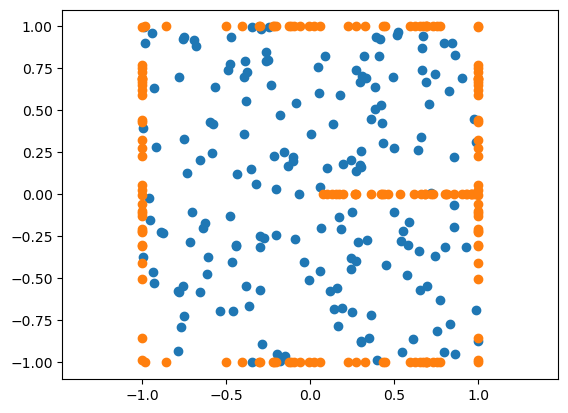

srnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: 0.056681323796510696 loss_r: 0.056681323796510696
epoch: 100 loss: -0.10609740018844604 loss_r: -0.10609740018844604
epoch: 200 loss: -0.12006503343582153 loss_r: -0.12006503343582153
epoch: 300 loss: -0.0843363031744957 loss_r: -0.0843363031744957
epoch: 400 loss: -0.1148650273680687 loss_r: -0.1148650273680687
epoch: 500 loss: -0.11291109025478363 loss_r: -0.11291109025478363
epoch: 600 loss: -0.10515192151069641 loss_r: -0.10515192151069641
epoch: 700 loss: -0.09815393388271332 loss_r: -0.09815393388271332
epoch: 800 loss: -0.10564716905355453 loss_r: -0.10564716905355453
epoch: 900 loss: -0.10049658268690109 loss_r: -0.10049658268690109
epoch: 1000 loss: -0.08587188273668289 loss_r: -0.08587188273668289
epoch: 1100 loss: -0.10510863363742828 loss_r: -0.10510863363742828
epoch: 1200 loss: -0.09444576501846313 loss_r: -0.09444576501846313
epoch: 1300 loss: -0.1156909242272377 loss_r: -0.1156909242272377
epoch: 1400 loss: -0.12109842151403427 loss_r: -0.1210984215140342

epoch: 12100 loss: -0.12485101073980331 loss_r: -0.12485101073980331
epoch: 12200 loss: -0.10049830377101898 loss_r: -0.10049830377101898
epoch: 12300 loss: -0.10622762143611908 loss_r: -0.10622762143611908
epoch: 12400 loss: -0.09262143820524216 loss_r: -0.09262143820524216
epoch: 12500 loss: -0.11973996460437775 loss_r: -0.11973996460437775
epoch: 12600 loss: -0.10862156003713608 loss_r: -0.10862156003713608
epoch: 12700 loss: -0.11657468974590302 loss_r: -0.11657468974590302
epoch: 12800 loss: -0.11570689082145691 loss_r: -0.11570689082145691
epoch: 12900 loss: -0.11790148168802261 loss_r: -0.11790148168802261
epoch: 13000 loss: -0.10436166077852249 loss_r: -0.10436166077852249
epoch: 13100 loss: -0.10268973559141159 loss_r: -0.10268973559141159
epoch: 13200 loss: -0.12459463626146317 loss_r: -0.12459463626146317
epoch: 13300 loss: -0.11053314059972763 loss_r: -0.11053314059972763
epoch: 13400 loss: -0.111078180372715 loss_r: -0.111078180372715
epoch: 13500 loss: -0.1124504134058952

epoch: 24100 loss: -0.0963376984000206 loss_r: -0.0963376984000206
epoch: 24200 loss: -0.09998998045921326 loss_r: -0.09998998045921326
epoch: 24300 loss: -0.11409011483192444 loss_r: -0.11409011483192444
epoch: 24400 loss: -0.10665003955364227 loss_r: -0.10665003955364227
epoch: 24500 loss: -0.13198335468769073 loss_r: -0.13198335468769073
epoch: 24600 loss: -0.09820659458637238 loss_r: -0.09820659458637238
epoch: 24700 loss: -0.11708302050828934 loss_r: -0.11708302050828934
epoch: 24800 loss: -0.11518014967441559 loss_r: -0.11518014967441559
epoch: 24900 loss: -0.10337354987859726 loss_r: -0.10337354987859726
epoch: 25000 loss: -0.10211801528930664 loss_r: -0.10211801528930664
epoch: 25100 loss: -0.11472747474908829 loss_r: -0.11472747474908829
epoch: 25200 loss: -0.10795038193464279 loss_r: -0.10795038193464279
epoch: 25300 loss: -0.11273857206106186 loss_r: -0.11273857206106186
epoch: 25400 loss: -0.10934991389513016 loss_r: -0.10934991389513016
epoch: 25500 loss: -0.12511701881885

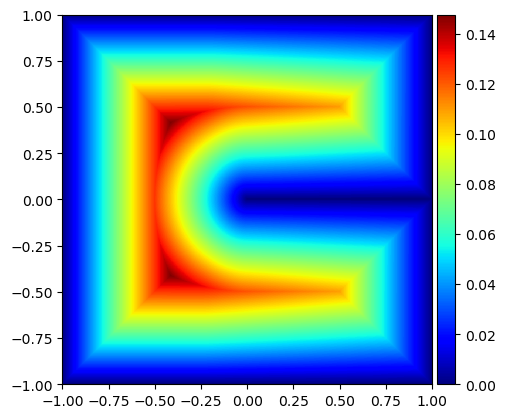

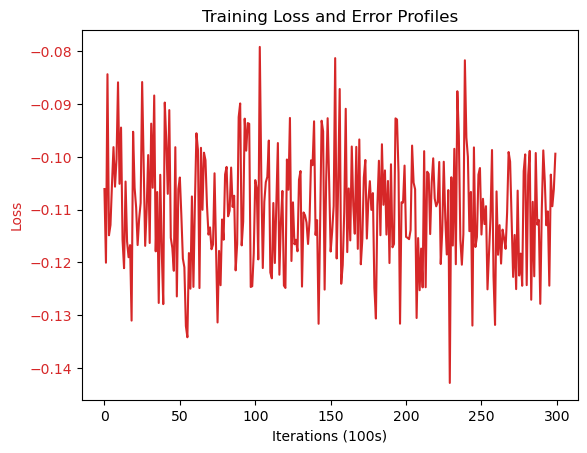

In [26]:
main_original(arch='srnn_ReLU', epochs=30000)

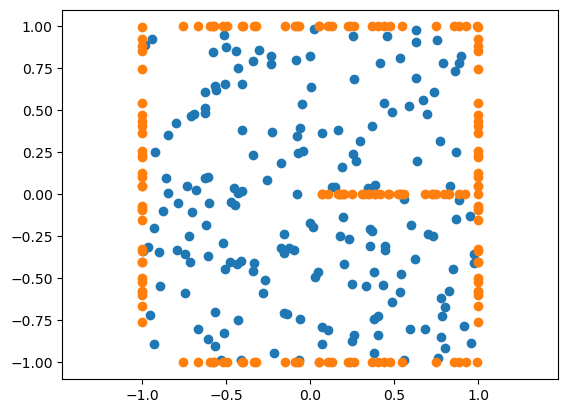

srnn_ReLU


IntProgress(value=0, max=600)

epoch: 0 loss: 0.025946225970983505 loss_r: 0.025946225970983505
epoch: 100 loss: -0.09759438037872314 loss_r: -0.09759438037872314
epoch: 200 loss: -0.11097952723503113 loss_r: -0.11097952723503113
epoch: 300 loss: -0.1133856400847435 loss_r: -0.1133856400847435
epoch: 400 loss: -0.11750295013189316 loss_r: -0.11750295013189316
epoch: 500 loss: -0.1054450124502182 loss_r: -0.1054450124502182
epoch: 600 loss: -0.10132705420255661 loss_r: -0.10132705420255661
epoch: 700 loss: -0.1076887771487236 loss_r: -0.1076887771487236
epoch: 800 loss: -0.12478000670671463 loss_r: -0.12478000670671463
epoch: 900 loss: -0.123444102704525 loss_r: -0.123444102704525
epoch: 1000 loss: -0.11514973640441895 loss_r: -0.11514973640441895
epoch: 1100 loss: -0.10618729144334793 loss_r: -0.10618729144334793
epoch: 1200 loss: -0.09816069900989532 loss_r: -0.09816069900989532
epoch: 1300 loss: -0.11670675128698349 loss_r: -0.11670675128698349
epoch: 1400 loss: -0.09373221546411514 loss_r: -0.09373221546411514
ep

epoch: 12100 loss: -0.11211424320936203 loss_r: -0.11211424320936203
epoch: 12200 loss: -0.11485369503498077 loss_r: -0.11485369503498077
epoch: 12300 loss: -0.11482440680265427 loss_r: -0.11482440680265427
epoch: 12400 loss: -0.11929459869861603 loss_r: -0.11929459869861603
epoch: 12500 loss: -0.12473268061876297 loss_r: -0.12473268061876297
epoch: 12600 loss: -0.09704215824604034 loss_r: -0.09704215824604034
epoch: 12700 loss: -0.10576155036687851 loss_r: -0.10576155036687851
epoch: 12800 loss: -0.11317295581102371 loss_r: -0.11317295581102371
epoch: 12900 loss: -0.11681704968214035 loss_r: -0.11681704968214035
epoch: 13000 loss: -0.1072075292468071 loss_r: -0.1072075292468071
epoch: 13100 loss: -0.106774240732193 loss_r: -0.106774240732193
epoch: 13200 loss: -0.10905010253190994 loss_r: -0.10905010253190994
epoch: 13300 loss: -0.12436757236719131 loss_r: -0.12436757236719131
epoch: 13400 loss: -0.13082239031791687 loss_r: -0.13082239031791687
epoch: 13500 loss: -0.11620240658521652 

epoch: 24100 loss: -0.1075049415230751 loss_r: -0.1075049415230751
epoch: 24200 loss: -0.09784001857042313 loss_r: -0.09784001857042313
epoch: 24300 loss: -0.11719759553670883 loss_r: -0.11719759553670883
epoch: 24400 loss: -0.11154370754957199 loss_r: -0.11154370754957199
epoch: 24500 loss: -0.11325392872095108 loss_r: -0.11325392872095108
epoch: 24600 loss: -0.12215886265039444 loss_r: -0.12215886265039444
epoch: 24700 loss: -0.09800074249505997 loss_r: -0.09800074249505997
epoch: 24800 loss: -0.12603753805160522 loss_r: -0.12603753805160522
epoch: 24900 loss: -0.1166749820113182 loss_r: -0.1166749820113182
epoch: 25000 loss: -0.1073414757847786 loss_r: -0.1073414757847786
epoch: 25100 loss: -0.09491971135139465 loss_r: -0.09491971135139465
epoch: 25200 loss: -0.10622745752334595 loss_r: -0.10622745752334595
epoch: 25300 loss: -0.12227872014045715 loss_r: -0.12227872014045715
epoch: 25400 loss: -0.12487193197011948 loss_r: -0.12487193197011948
epoch: 25500 loss: -0.11823821812868118 

epoch: 36100 loss: -0.10532684624195099 loss_r: -0.10532684624195099
epoch: 36200 loss: -0.10573101043701172 loss_r: -0.10573101043701172
epoch: 36300 loss: -0.11970583349466324 loss_r: -0.11970583349466324
epoch: 36400 loss: -0.12332556396722794 loss_r: -0.12332556396722794
epoch: 36500 loss: -0.12464451044797897 loss_r: -0.12464451044797897
epoch: 36600 loss: -0.10469016432762146 loss_r: -0.10469016432762146
epoch: 36700 loss: -0.12045127898454666 loss_r: -0.12045127898454666
epoch: 36800 loss: -0.11541696637868881 loss_r: -0.11541696637868881
epoch: 36900 loss: -0.09651780128479004 loss_r: -0.09651780128479004
epoch: 37000 loss: -0.10276506096124649 loss_r: -0.10276506096124649
epoch: 37100 loss: -0.12459664791822433 loss_r: -0.12459664791822433
epoch: 37200 loss: -0.11181540042161942 loss_r: -0.11181540042161942
epoch: 37300 loss: -0.12289764732122421 loss_r: -0.12289764732122421
epoch: 37400 loss: -0.11547190696001053 loss_r: -0.11547190696001053
epoch: 37500 loss: -0.122589215636

epoch: 48100 loss: -0.10783129185438156 loss_r: -0.10783129185438156
epoch: 48200 loss: -0.11339350789785385 loss_r: -0.11339350789785385
epoch: 48300 loss: -0.10124584287405014 loss_r: -0.10124584287405014
epoch: 48400 loss: -0.1078917607665062 loss_r: -0.1078917607665062
epoch: 48500 loss: -0.12229368835687637 loss_r: -0.12229368835687637
epoch: 48600 loss: -0.10682175308465958 loss_r: -0.10682175308465958
epoch: 48700 loss: -0.12430029362440109 loss_r: -0.12430029362440109
epoch: 48800 loss: -0.11317508667707443 loss_r: -0.11317508667707443
epoch: 48900 loss: -0.13185642659664154 loss_r: -0.13185642659664154
epoch: 49000 loss: -0.10874110460281372 loss_r: -0.10874110460281372
epoch: 49100 loss: -0.11156594008207321 loss_r: -0.11156594008207321
epoch: 49200 loss: -0.08896920084953308 loss_r: -0.08896920084953308
epoch: 49300 loss: -0.0990278497338295 loss_r: -0.0990278497338295
epoch: 49400 loss: -0.11296022683382034 loss_r: -0.11296022683382034
epoch: 49500 loss: -0.1067391708493232

torch.Size([1002001, 1]) torch.Size([1002001, 1])


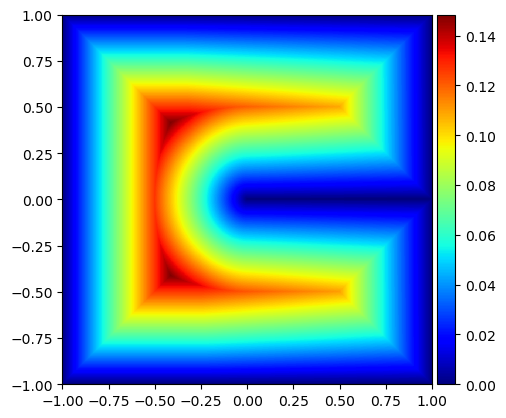

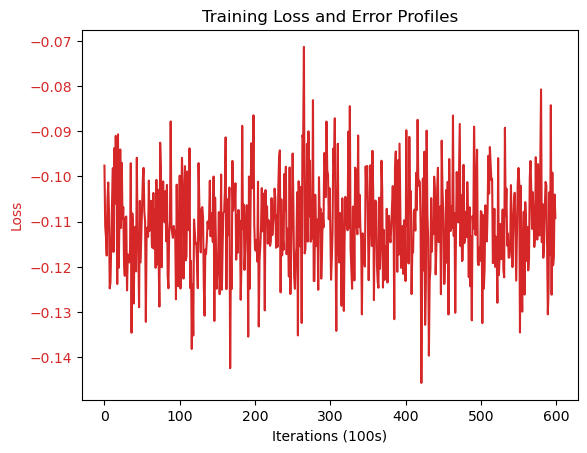

In [17]:
main_original(arch='srnn_ReLU', epochs=60000)

### Shallow NN, Tanh Activation

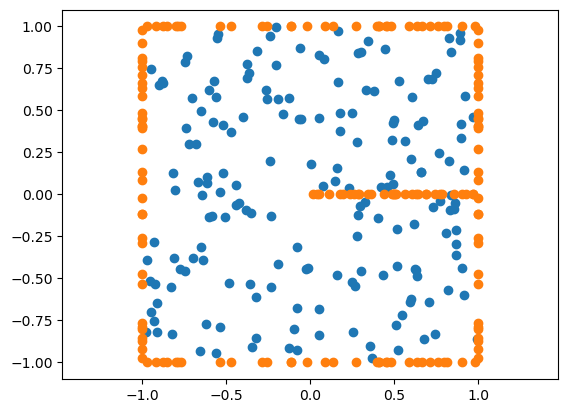

srnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: 0.12121424823999405 loss_r: 0.12121424823999405
epoch: 100 loss: -0.10871151089668274 loss_r: -0.10871151089668274
epoch: 200 loss: -0.12191934883594513 loss_r: -0.12191934883594513
epoch: 300 loss: -0.11590632796287537 loss_r: -0.11590632796287537
epoch: 400 loss: -0.09996949136257172 loss_r: -0.09996949136257172
epoch: 500 loss: -0.10761105269193649 loss_r: -0.10761105269193649
epoch: 600 loss: -0.11910411715507507 loss_r: -0.11910411715507507
epoch: 700 loss: -0.1032663881778717 loss_r: -0.1032663881778717
epoch: 800 loss: -0.09777786582708359 loss_r: -0.09777786582708359
epoch: 900 loss: -0.10198517143726349 loss_r: -0.10198517143726349
epoch: 1000 loss: -0.09555182605981827 loss_r: -0.09555182605981827
epoch: 1100 loss: -0.0977708250284195 loss_r: -0.0977708250284195
epoch: 1200 loss: -0.10857874900102615 loss_r: -0.10857874900102615
epoch: 1300 loss: -0.11136345565319061 loss_r: -0.11136345565319061
epoch: 1400 loss: -0.10567377507686615 loss_r: -0.1056737750768661

epoch: 12200 loss: -0.1501474678516388 loss_r: -0.1501474678516388
epoch: 12300 loss: -0.14084585011005402 loss_r: -0.14084585011005402
epoch: 12400 loss: -0.1304544359445572 loss_r: -0.1304544359445572
epoch: 12500 loss: -0.11388581246137619 loss_r: -0.11388581246137619
epoch: 12600 loss: -0.11524004489183426 loss_r: -0.11524004489183426
epoch: 12700 loss: -0.17617946863174438 loss_r: -0.17617946863174438
epoch: 12800 loss: -0.16217434406280518 loss_r: -0.16217434406280518
epoch: 12900 loss: -0.1517016440629959 loss_r: -0.1517016440629959
epoch: 13000 loss: -0.13564763963222504 loss_r: -0.13564763963222504
epoch: 13100 loss: -0.1613079011440277 loss_r: -0.1613079011440277
epoch: 13200 loss: -0.13489662110805511 loss_r: -0.13489662110805511
epoch: 13300 loss: -0.15112203359603882 loss_r: -0.15112203359603882
epoch: 13400 loss: -0.14955826103687286 loss_r: -0.14955826103687286
epoch: 13500 loss: -0.10524052381515503 loss_r: -0.10524052381515503
epoch: 13600 loss: -0.18444068729877472 lo

epoch: 24200 loss: -0.10136491805315018 loss_r: -0.10136491805315018
epoch: 24300 loss: -0.136118546128273 loss_r: -0.136118546128273
epoch: 24400 loss: -0.12542542815208435 loss_r: -0.12542542815208435
epoch: 24500 loss: -0.17717596888542175 loss_r: -0.17717596888542175
epoch: 24600 loss: -0.14340247213840485 loss_r: -0.14340247213840485
epoch: 24700 loss: -0.1445537656545639 loss_r: -0.1445537656545639
epoch: 24800 loss: -0.1533905267715454 loss_r: -0.1533905267715454
epoch: 24900 loss: -0.17023387551307678 loss_r: -0.17023387551307678
epoch: 25000 loss: -0.13769806921482086 loss_r: -0.13769806921482086
epoch: 25100 loss: -0.1367860734462738 loss_r: -0.1367860734462738
epoch: 25200 loss: -0.14545434713363647 loss_r: -0.14545434713363647
epoch: 25300 loss: -0.11925145983695984 loss_r: -0.11925145983695984
epoch: 25400 loss: -0.15704870223999023 loss_r: -0.15704870223999023
epoch: 25500 loss: -0.14947542548179626 loss_r: -0.14947542548179626
epoch: 25600 loss: -0.15266914665699005 loss

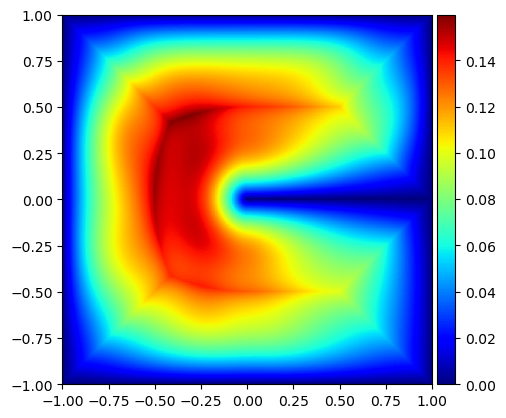

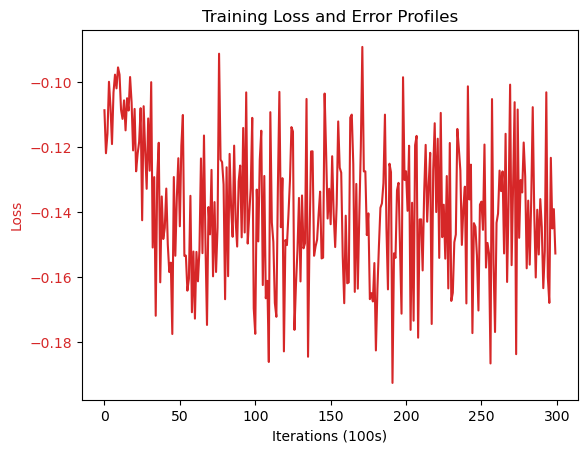

In [24]:
main_original(arch='srnn_Tanh', epochs=30000)

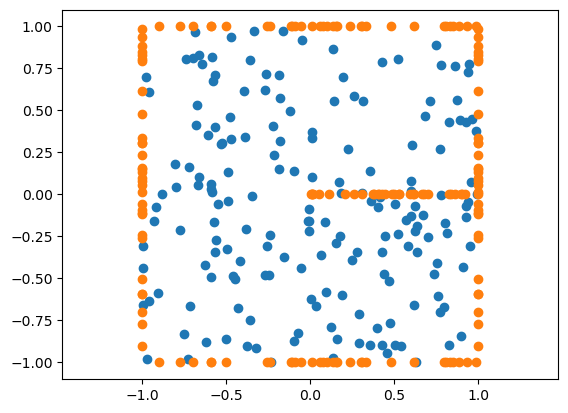

srnn_Tanh


IntProgress(value=0, max=600)

epoch: 0 loss: 0.2958563268184662 loss_r: 0.2958563268184662
epoch: 100 loss: -0.1132809966802597 loss_r: -0.1132809966802597
epoch: 200 loss: -0.11010371893644333 loss_r: -0.11010371893644333
epoch: 300 loss: -0.10348907113075256 loss_r: -0.10348907113075256
epoch: 400 loss: -0.1016506627202034 loss_r: -0.1016506627202034
epoch: 500 loss: -0.10393235087394714 loss_r: -0.10393235087394714
epoch: 600 loss: -0.10751035064458847 loss_r: -0.10751035064458847
epoch: 700 loss: -0.10426703840494156 loss_r: -0.10426703840494156
epoch: 800 loss: -0.1159856766462326 loss_r: -0.1159856766462326
epoch: 900 loss: -0.11796519160270691 loss_r: -0.11796519160270691
epoch: 1000 loss: -0.10987506806850433 loss_r: -0.10987506806850433
epoch: 1100 loss: -0.10191802680492401 loss_r: -0.10191802680492401
epoch: 1200 loss: -0.12098861485719681 loss_r: -0.12098861485719681
epoch: 1300 loss: -0.09919018298387527 loss_r: -0.09919018298387527
epoch: 1400 loss: -0.11743520945310593 loss_r: -0.11743520945310593
ep

epoch: 12200 loss: -0.13916973769664764 loss_r: -0.13916973769664764
epoch: 12300 loss: -0.17525388300418854 loss_r: -0.17525388300418854
epoch: 12400 loss: -0.13065335154533386 loss_r: -0.13065335154533386
epoch: 12500 loss: -0.14811787009239197 loss_r: -0.14811787009239197
epoch: 12600 loss: -0.16504280269145966 loss_r: -0.16504280269145966
epoch: 12700 loss: -0.1530504822731018 loss_r: -0.1530504822731018
epoch: 12800 loss: -0.11706236749887466 loss_r: -0.11706236749887466
epoch: 12900 loss: -0.14527210593223572 loss_r: -0.14527210593223572
epoch: 13000 loss: -0.1595838963985443 loss_r: -0.1595838963985443
epoch: 13100 loss: -0.1473778337240219 loss_r: -0.1473778337240219
epoch: 13200 loss: -0.14292588829994202 loss_r: -0.14292588829994202
epoch: 13300 loss: -0.09986254572868347 loss_r: -0.09986254572868347
epoch: 13400 loss: -0.11740602552890778 loss_r: -0.11740602552890778
epoch: 13500 loss: -0.11664823442697525 loss_r: -0.11664823442697525
epoch: 13600 loss: -0.17256277799606323 

epoch: 24200 loss: -0.155028834939003 loss_r: -0.155028834939003
epoch: 24300 loss: -0.1345801055431366 loss_r: -0.1345801055431366
epoch: 24400 loss: -0.13784219324588776 loss_r: -0.13784219324588776
epoch: 24500 loss: -0.10986132174730301 loss_r: -0.10986132174730301
epoch: 24600 loss: -0.14997079968452454 loss_r: -0.14997079968452454
epoch: 24700 loss: -0.14136312901973724 loss_r: -0.14136312901973724
epoch: 24800 loss: -0.1616620272397995 loss_r: -0.1616620272397995
epoch: 24900 loss: -0.16162444651126862 loss_r: -0.16162444651126862
epoch: 25000 loss: -0.13383989036083221 loss_r: -0.13383989036083221
epoch: 25100 loss: -0.12545163929462433 loss_r: -0.12545163929462433
epoch: 25200 loss: -0.13044221699237823 loss_r: -0.13044221699237823
epoch: 25300 loss: -0.18289871513843536 loss_r: -0.18289871513843536
epoch: 25400 loss: -0.1672208309173584 loss_r: -0.1672208309173584
epoch: 25500 loss: -0.15444140136241913 loss_r: -0.15444140136241913
epoch: 25600 loss: -0.14729571342468262 loss

epoch: 36300 loss: -0.14511387050151825 loss_r: -0.14511387050151825
epoch: 36400 loss: -0.1572633981704712 loss_r: -0.1572633981704712
epoch: 36500 loss: -0.1346060037612915 loss_r: -0.1346060037612915
epoch: 36600 loss: -0.15888454020023346 loss_r: -0.15888454020023346
epoch: 36700 loss: -0.14897221326828003 loss_r: -0.14897221326828003
epoch: 36800 loss: -0.13870468735694885 loss_r: -0.13870468735694885
epoch: 36900 loss: -0.15360189974308014 loss_r: -0.15360189974308014
epoch: 37000 loss: -0.1405380815267563 loss_r: -0.1405380815267563
epoch: 37100 loss: -0.15758322179317474 loss_r: -0.15758322179317474
epoch: 37200 loss: -0.12165730446577072 loss_r: -0.12165730446577072
epoch: 37300 loss: -0.1251143366098404 loss_r: -0.1251143366098404
epoch: 37400 loss: -0.14997498691082 loss_r: -0.14997498691082
epoch: 37500 loss: -0.15499134361743927 loss_r: -0.15499134361743927
epoch: 37600 loss: -0.09596119821071625 loss_r: -0.09596119821071625
epoch: 37700 loss: -0.16095077991485596 loss_r: 

epoch: 48300 loss: -0.15432649850845337 loss_r: -0.15432649850845337
epoch: 48400 loss: -0.1397767812013626 loss_r: -0.1397767812013626
epoch: 48500 loss: -0.1498507559299469 loss_r: -0.1498507559299469
epoch: 48600 loss: -0.13808684051036835 loss_r: -0.13808684051036835
epoch: 48700 loss: -0.17863468825817108 loss_r: -0.17863468825817108
epoch: 48800 loss: -0.12049586325883865 loss_r: -0.12049586325883865
epoch: 48900 loss: -0.12822988629341125 loss_r: -0.12822988629341125
epoch: 49000 loss: -0.1244325265288353 loss_r: -0.1244325265288353
epoch: 49100 loss: -0.15264591574668884 loss_r: -0.15264591574668884
epoch: 49200 loss: -0.1168259009718895 loss_r: -0.1168259009718895
epoch: 49300 loss: -0.13486814498901367 loss_r: -0.13486814498901367
epoch: 49400 loss: -0.16884389519691467 loss_r: -0.16884389519691467
epoch: 49500 loss: -0.14261610805988312 loss_r: -0.14261610805988312
epoch: 49600 loss: -0.15464329719543457 loss_r: -0.15464329719543457
epoch: 49700 loss: -0.1097540557384491 los

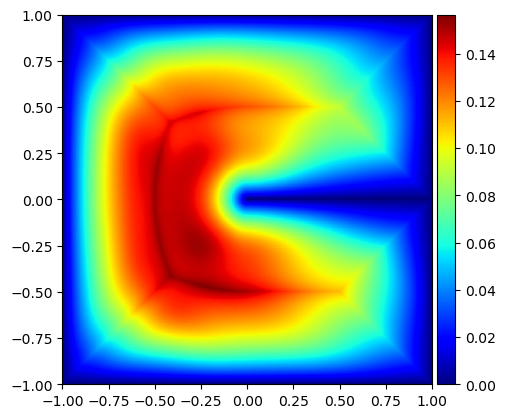

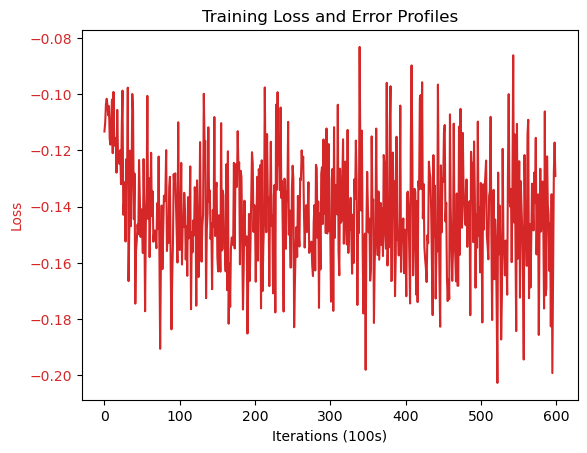

In [18]:
main_original(arch='srnn_Tanh', epochs=60000)

### Standard/Original Architecture, ReLU Activation

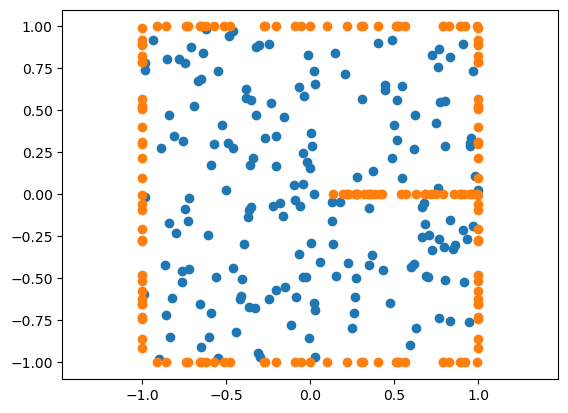

drrnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: 2.3690860271453857 loss_r: 2.3690860271453857
epoch: 100 loss: -0.10933569073677063 loss_r: -0.10933569073677063
epoch: 200 loss: -0.08850863575935364 loss_r: -0.08850863575935364
epoch: 300 loss: -0.10478996485471725 loss_r: -0.10478996485471725
epoch: 400 loss: -0.1018173098564148 loss_r: -0.1018173098564148
epoch: 500 loss: -0.11638908833265305 loss_r: -0.11638908833265305
epoch: 600 loss: -0.11325997859239578 loss_r: -0.11325997859239578
epoch: 700 loss: -0.10923584550619125 loss_r: -0.10923584550619125
epoch: 800 loss: -0.10514478385448456 loss_r: -0.10514478385448456
epoch: 900 loss: -0.10896860063076019 loss_r: -0.10896860063076019
epoch: 1000 loss: -0.10632840543985367 loss_r: -0.10632840543985367
epoch: 1100 loss: -0.09510742872953415 loss_r: -0.09510742872953415
epoch: 1200 loss: -0.10641961544752121 loss_r: -0.10641961544752121
epoch: 1300 loss: -0.10798875987529755 loss_r: -0.10798875987529755
epoch: 1400 loss: -0.09450744837522507 loss_r: -0.0945074483752250

epoch: 12100 loss: -0.10622371733188629 loss_r: -0.10622371733188629
epoch: 12200 loss: -0.1251821517944336 loss_r: -0.1251821517944336
epoch: 12300 loss: -0.09122002124786377 loss_r: -0.09122002124786377
epoch: 12400 loss: -0.10510421544313431 loss_r: -0.10510421544313431
epoch: 12500 loss: -0.110647052526474 loss_r: -0.110647052526474
epoch: 12600 loss: -0.10492813587188721 loss_r: -0.10492813587188721
epoch: 12700 loss: -0.10806804895401001 loss_r: -0.10806804895401001
epoch: 12800 loss: -0.12057007104158401 loss_r: -0.12057007104158401
epoch: 12900 loss: -0.10528621077537537 loss_r: -0.10528621077537537
epoch: 13000 loss: -0.09230069071054459 loss_r: -0.09230069071054459
epoch: 13100 loss: -0.11087547242641449 loss_r: -0.11087547242641449
epoch: 13200 loss: -0.0987643152475357 loss_r: -0.0987643152475357
epoch: 13300 loss: -0.10663330554962158 loss_r: -0.10663330554962158
epoch: 13400 loss: -0.11422063410282135 loss_r: -0.11422063410282135
epoch: 13500 loss: -0.12574225664138794 lo

epoch: 24100 loss: -0.11466487497091293 loss_r: -0.11466487497091293
epoch: 24200 loss: -0.11031822115182877 loss_r: -0.11031822115182877
epoch: 24300 loss: -0.11559618264436722 loss_r: -0.11559618264436722
epoch: 24400 loss: -0.10338611155748367 loss_r: -0.10338611155748367
epoch: 24500 loss: -0.10556130856275558 loss_r: -0.10556130856275558
epoch: 24600 loss: -0.10658711194992065 loss_r: -0.10658711194992065
epoch: 24700 loss: -0.10719620436429977 loss_r: -0.10719620436429977
epoch: 24800 loss: -0.10705966502428055 loss_r: -0.10705966502428055
epoch: 24900 loss: -0.11688003689050674 loss_r: -0.11688003689050674
epoch: 25000 loss: -0.10399173200130463 loss_r: -0.10399173200130463
epoch: 25100 loss: -0.1147107258439064 loss_r: -0.1147107258439064
epoch: 25200 loss: -0.11815106123685837 loss_r: -0.11815106123685837
epoch: 25300 loss: -0.11694181710481644 loss_r: -0.11694181710481644
epoch: 25400 loss: -0.1148490384221077 loss_r: -0.1148490384221077
epoch: 25500 loss: -0.1108973324298858

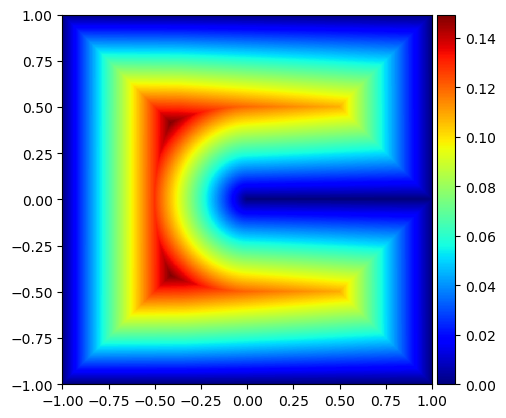

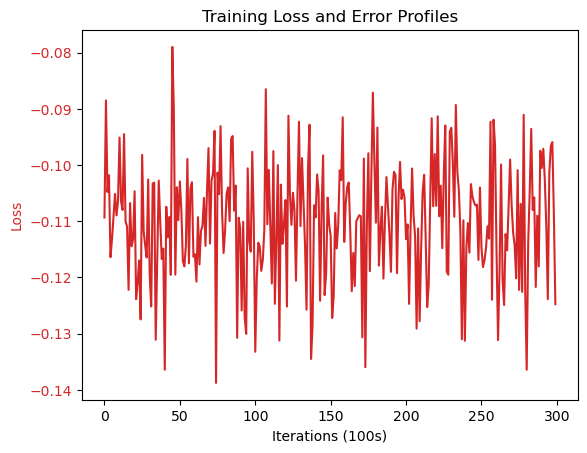

In [27]:
main_original(arch='drrnn_ReLU', epochs=30000)

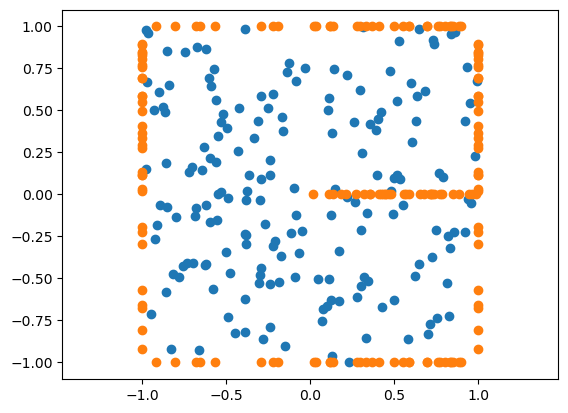

drrnn_ReLU


IntProgress(value=0, max=600)

epoch: 0 loss: 5.636562347412109 loss_r: 5.636562347412109
epoch: 100 loss: -0.09528330713510513 loss_r: -0.09528330713510513
epoch: 200 loss: -0.08671974390745163 loss_r: -0.08671974390745163
epoch: 300 loss: -0.09262767434120178 loss_r: -0.09262767434120178
epoch: 400 loss: -0.09748359769582748 loss_r: -0.09748359769582748
epoch: 500 loss: -0.1082514300942421 loss_r: -0.1082514300942421
epoch: 600 loss: -0.10144615918397903 loss_r: -0.10144615918397903
epoch: 700 loss: -0.11228794604539871 loss_r: -0.11228794604539871
epoch: 800 loss: -0.10415130853652954 loss_r: -0.10415130853652954
epoch: 900 loss: -0.10403694212436676 loss_r: -0.10403694212436676
epoch: 1000 loss: -0.1249856948852539 loss_r: -0.1249856948852539
epoch: 1100 loss: -0.09332013130187988 loss_r: -0.09332013130187988
epoch: 1200 loss: -0.09476663917303085 loss_r: -0.09476663917303085
epoch: 1300 loss: -0.11164572089910507 loss_r: -0.11164572089910507
epoch: 1400 loss: -0.10770125687122345 loss_r: -0.10770125687122345
ep

epoch: 12200 loss: -0.0880303755402565 loss_r: -0.0880303755402565
epoch: 12300 loss: -0.11428945511579514 loss_r: -0.11428945511579514
epoch: 12400 loss: -0.10852153599262238 loss_r: -0.10852153599262238
epoch: 12500 loss: -0.1150619387626648 loss_r: -0.1150619387626648
epoch: 12600 loss: -0.09975004196166992 loss_r: -0.09975004196166992
epoch: 12700 loss: -0.10532667487859726 loss_r: -0.10532667487859726
epoch: 12800 loss: -0.11071417480707169 loss_r: -0.11071417480707169
epoch: 12900 loss: -0.1268746256828308 loss_r: -0.1268746256828308
epoch: 13000 loss: -0.08738316595554352 loss_r: -0.08738316595554352
epoch: 13100 loss: -0.12858815491199493 loss_r: -0.12858815491199493
epoch: 13200 loss: -0.09999627619981766 loss_r: -0.09999627619981766
epoch: 13300 loss: -0.1051759421825409 loss_r: -0.1051759421825409
epoch: 13400 loss: -0.11146792024374008 loss_r: -0.11146792024374008
epoch: 13500 loss: -0.10792336612939835 loss_r: -0.10792336612939835
epoch: 13600 loss: -0.11609738320112228 lo

epoch: 24200 loss: -0.11212994158267975 loss_r: -0.11212994158267975
epoch: 24300 loss: -0.10297465324401855 loss_r: -0.10297465324401855
epoch: 24400 loss: -0.11454570293426514 loss_r: -0.11454570293426514
epoch: 24500 loss: -0.10821936279535294 loss_r: -0.10821936279535294
epoch: 24600 loss: -0.11599823087453842 loss_r: -0.11599823087453842
epoch: 24700 loss: -0.12241898477077484 loss_r: -0.12241898477077484
epoch: 24800 loss: -0.12298551946878433 loss_r: -0.12298551946878433
epoch: 24900 loss: -0.10646659880876541 loss_r: -0.10646659880876541
epoch: 25000 loss: -0.111321359872818 loss_r: -0.111321359872818
epoch: 25100 loss: -0.09243609011173248 loss_r: -0.09243609011173248
epoch: 25200 loss: -0.11807339638471603 loss_r: -0.11807339638471603
epoch: 25300 loss: -0.12745100259780884 loss_r: -0.12745100259780884
epoch: 25400 loss: -0.09409354627132416 loss_r: -0.09409354627132416
epoch: 25500 loss: -0.11381726711988449 loss_r: -0.11381726711988449
epoch: 25600 loss: -0.0915594249963760

epoch: 36200 loss: -0.10973045974969864 loss_r: -0.10973045974969864
epoch: 36300 loss: -0.1322314739227295 loss_r: -0.1322314739227295
epoch: 36400 loss: -0.10698018223047256 loss_r: -0.10698018223047256
epoch: 36500 loss: -0.11699186265468597 loss_r: -0.11699186265468597
epoch: 36600 loss: -0.11973991990089417 loss_r: -0.11973991990089417
epoch: 36700 loss: -0.10234911739826202 loss_r: -0.10234911739826202
epoch: 36800 loss: -0.094904825091362 loss_r: -0.094904825091362
epoch: 36900 loss: -0.12221416085958481 loss_r: -0.12221416085958481
epoch: 37000 loss: -0.10598199814558029 loss_r: -0.10598199814558029
epoch: 37100 loss: -0.12441305071115494 loss_r: -0.12441305071115494
epoch: 37200 loss: -0.110075443983078 loss_r: -0.110075443983078
epoch: 37300 loss: -0.12310835719108582 loss_r: -0.12310835719108582
epoch: 37400 loss: -0.1153210774064064 loss_r: -0.1153210774064064
epoch: 37500 loss: -0.1196957528591156 loss_r: -0.1196957528591156
epoch: 37600 loss: -0.11345742642879486 loss_r: 

epoch: 48200 loss: -0.1004033163189888 loss_r: -0.1004033163189888
epoch: 48300 loss: -0.10709583014249802 loss_r: -0.10709583014249802
epoch: 48400 loss: -0.09334080666303635 loss_r: -0.09334080666303635
epoch: 48500 loss: -0.11027662456035614 loss_r: -0.11027662456035614
epoch: 48600 loss: -0.10119451582431793 loss_r: -0.10119451582431793
epoch: 48700 loss: -0.09374672919511795 loss_r: -0.09374672919511795
epoch: 48800 loss: -0.09119002521038055 loss_r: -0.09119002521038055
epoch: 48900 loss: -0.11901304870843887 loss_r: -0.11901304870843887
epoch: 49000 loss: -0.11441896110773087 loss_r: -0.11441896110773087
epoch: 49100 loss: -0.11756093800067902 loss_r: -0.11756093800067902
epoch: 49200 loss: -0.11882373690605164 loss_r: -0.11882373690605164
epoch: 49300 loss: -0.11680402606725693 loss_r: -0.11680402606725693
epoch: 49400 loss: -0.10895043611526489 loss_r: -0.10895043611526489
epoch: 49500 loss: -0.12422122061252594 loss_r: -0.12422122061252594
epoch: 49600 loss: -0.11885760724544

torch.Size([1002001, 1]) torch.Size([1002001, 1])


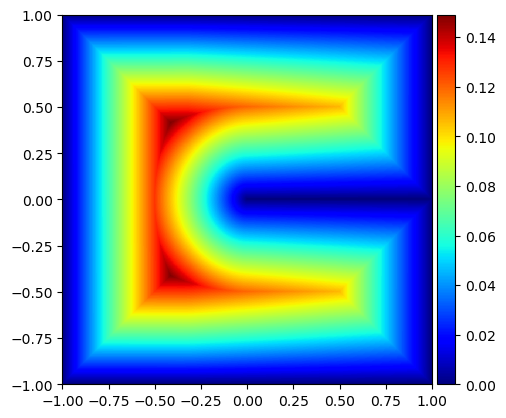

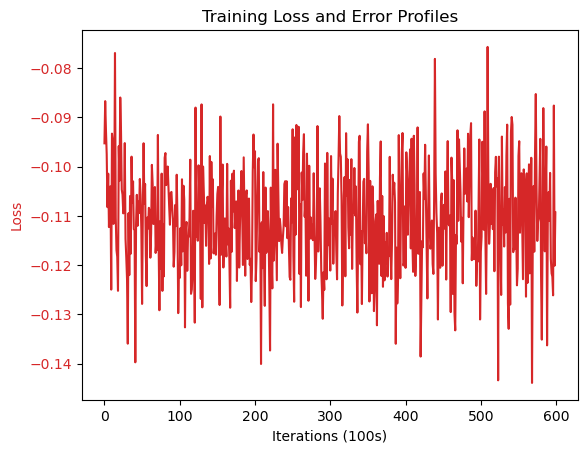

In [19]:
main_original(arch='drrnn_ReLU', epochs=60000)

### Standard/Original Architecture, Tanh Activation

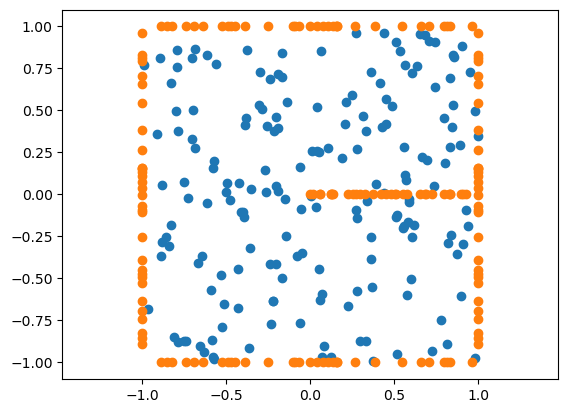

drrnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: 0.9224117398262024 loss_r: 0.9224117398262024
epoch: 100 loss: -0.11211740970611572 loss_r: -0.11211740970611572
epoch: 200 loss: -0.11416985839605331 loss_r: -0.11416985839605331
epoch: 300 loss: -0.13708025217056274 loss_r: -0.13708025217056274
epoch: 400 loss: -0.14040853083133698 loss_r: -0.14040853083133698
epoch: 500 loss: -0.13621065020561218 loss_r: -0.13621065020561218
epoch: 600 loss: -0.1511698067188263 loss_r: -0.1511698067188263
epoch: 700 loss: -0.12772709131240845 loss_r: -0.12772709131240845
epoch: 800 loss: -0.119429811835289 loss_r: -0.119429811835289
epoch: 900 loss: -0.11945682018995285 loss_r: -0.11945682018995285
epoch: 1000 loss: -0.1460839807987213 loss_r: -0.1460839807987213
epoch: 1100 loss: -0.09568078070878983 loss_r: -0.09568078070878983
epoch: 1200 loss: -0.12536311149597168 loss_r: -0.12536311149597168
epoch: 1300 loss: -0.12474405765533447 loss_r: -0.12474405765533447
epoch: 1400 loss: -0.11843452602624893 loss_r: -0.11843452602624893
epoc

epoch: 12200 loss: -0.16743485629558563 loss_r: -0.16743485629558563
epoch: 12300 loss: -0.1372322142124176 loss_r: -0.1372322142124176
epoch: 12400 loss: -0.20906513929367065 loss_r: -0.20906513929367065
epoch: 12500 loss: -0.14951583743095398 loss_r: -0.14951583743095398
epoch: 12600 loss: -0.16958478093147278 loss_r: -0.16958478093147278
epoch: 12700 loss: -0.15332062542438507 loss_r: -0.15332062542438507
epoch: 12800 loss: -0.1628168374300003 loss_r: -0.1628168374300003
epoch: 12900 loss: -0.17382358014583588 loss_r: -0.17382358014583588
epoch: 13000 loss: -0.1897720843553543 loss_r: -0.1897720843553543
epoch: 13100 loss: -0.16736577451229095 loss_r: -0.16736577451229095
epoch: 13200 loss: -0.11739171296358109 loss_r: -0.11739171296358109
epoch: 13300 loss: -0.17305807769298553 loss_r: -0.17305807769298553
epoch: 13400 loss: -0.16383464634418488 loss_r: -0.16383464634418488
epoch: 13500 loss: -0.13970117270946503 loss_r: -0.13970117270946503
epoch: 13600 loss: -0.1493176519870758 l

epoch: 24200 loss: -0.1496451199054718 loss_r: -0.1496451199054718
epoch: 24300 loss: -0.1650339961051941 loss_r: -0.1650339961051941
epoch: 24400 loss: -0.17018431425094604 loss_r: -0.17018431425094604
epoch: 24500 loss: -0.15864382684230804 loss_r: -0.15864382684230804
epoch: 24600 loss: -0.13619154691696167 loss_r: -0.13619154691696167
epoch: 24700 loss: -0.1567491888999939 loss_r: -0.1567491888999939
epoch: 24800 loss: -0.1835668832063675 loss_r: -0.1835668832063675
epoch: 24900 loss: -0.17258243262767792 loss_r: -0.17258243262767792
epoch: 25000 loss: -0.13169141113758087 loss_r: -0.13169141113758087
epoch: 25100 loss: -0.14067038893699646 loss_r: -0.14067038893699646
epoch: 25200 loss: -0.14296072721481323 loss_r: -0.14296072721481323
epoch: 25300 loss: -0.17051145434379578 loss_r: -0.17051145434379578
epoch: 25400 loss: -0.1830405592918396 loss_r: -0.1830405592918396
epoch: 25500 loss: -0.12930338084697723 loss_r: -0.12930338084697723
epoch: 25600 loss: -0.17700856924057007 loss

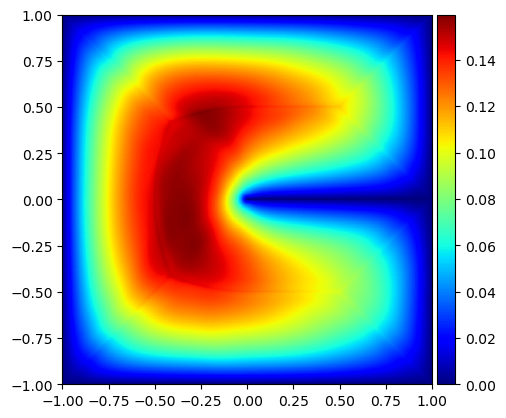

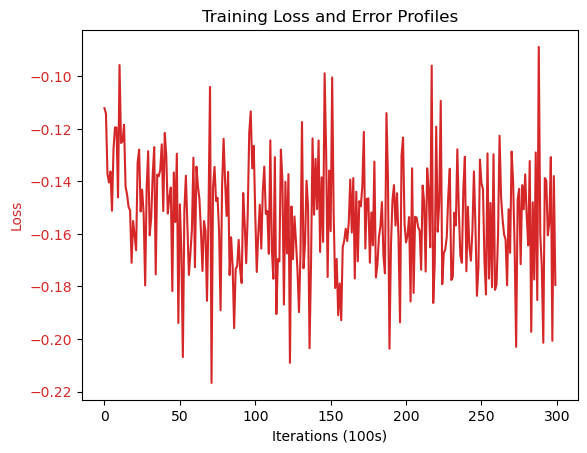

In [25]:
main_original(arch='drrnn_Tanh', epochs=30000)

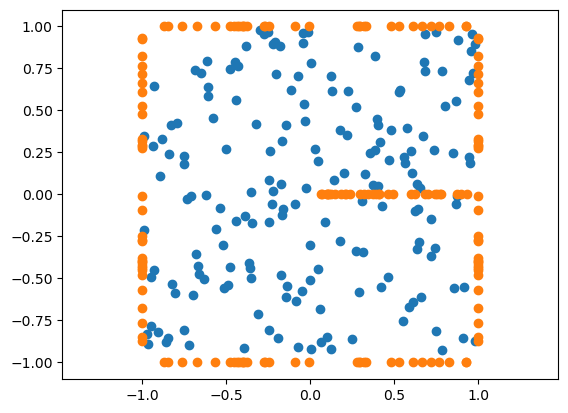

drrnn_Tanh


IntProgress(value=0, max=600)

epoch: 0 loss: 33.40950012207031 loss_r: 33.40950012207031
epoch: 100 loss: -0.08598782122135162 loss_r: -0.08598782122135162
epoch: 200 loss: -0.1224302351474762 loss_r: -0.1224302351474762
epoch: 300 loss: -0.1332935243844986 loss_r: -0.1332935243844986
epoch: 400 loss: -0.11392759531736374 loss_r: -0.11392759531736374
epoch: 500 loss: -0.12255238741636276 loss_r: -0.12255238741636276
epoch: 600 loss: -0.09730186313390732 loss_r: -0.09730186313390732
epoch: 700 loss: -0.1211901381611824 loss_r: -0.1211901381611824
epoch: 800 loss: -0.1236175075173378 loss_r: -0.1236175075173378
epoch: 900 loss: -0.12721000611782074 loss_r: -0.12721000611782074
epoch: 1000 loss: -0.1154099777340889 loss_r: -0.1154099777340889
epoch: 1100 loss: -0.1314057856798172 loss_r: -0.1314057856798172
epoch: 1200 loss: -0.11417373269796371 loss_r: -0.11417373269796371
epoch: 1300 loss: -0.15058812499046326 loss_r: -0.15058812499046326
epoch: 1400 loss: -0.09279817342758179 loss_r: -0.09279817342758179
epoch: 150

epoch: 12200 loss: -0.14334678649902344 loss_r: -0.14334678649902344
epoch: 12300 loss: -0.15251651406288147 loss_r: -0.15251651406288147
epoch: 12400 loss: -0.13461001217365265 loss_r: -0.13461001217365265
epoch: 12500 loss: -0.15958447754383087 loss_r: -0.15958447754383087
epoch: 12600 loss: -0.1418401598930359 loss_r: -0.1418401598930359
epoch: 12700 loss: -0.11684062331914902 loss_r: -0.11684062331914902
epoch: 12800 loss: -0.11981245130300522 loss_r: -0.11981245130300522
epoch: 12900 loss: -0.14843964576721191 loss_r: -0.14843964576721191
epoch: 13000 loss: -0.1640152484178543 loss_r: -0.1640152484178543
epoch: 13100 loss: -0.14918209612369537 loss_r: -0.14918209612369537
epoch: 13200 loss: -0.13691085577011108 loss_r: -0.13691085577011108
epoch: 13300 loss: -0.15905381739139557 loss_r: -0.15905381739139557
epoch: 13400 loss: -0.1638551503419876 loss_r: -0.1638551503419876
epoch: 13500 loss: -0.16047435998916626 loss_r: -0.16047435998916626
epoch: 13600 loss: -0.12684334814548492 

epoch: 24200 loss: -0.1681232750415802 loss_r: -0.1681232750415802
epoch: 24300 loss: -0.12966124713420868 loss_r: -0.12966124713420868
epoch: 24400 loss: -0.11924207210540771 loss_r: -0.11924207210540771
epoch: 24500 loss: -0.1057315319776535 loss_r: -0.1057315319776535
epoch: 24600 loss: -0.13074807822704315 loss_r: -0.13074807822704315
epoch: 24700 loss: -0.20633244514465332 loss_r: -0.20633244514465332
epoch: 24800 loss: -0.17191365361213684 loss_r: -0.17191365361213684
epoch: 24900 loss: -0.1112600713968277 loss_r: -0.1112600713968277
epoch: 25000 loss: -0.15490290522575378 loss_r: -0.15490290522575378
epoch: 25100 loss: -0.2030121088027954 loss_r: -0.2030121088027954
epoch: 25200 loss: -0.11828150600194931 loss_r: -0.11828150600194931
epoch: 25300 loss: -0.18672113120555878 loss_r: -0.18672113120555878
epoch: 25400 loss: -0.13473093509674072 loss_r: -0.13473093509674072
epoch: 25500 loss: -0.14556634426116943 loss_r: -0.14556634426116943
epoch: 25600 loss: -0.15630517899990082 lo

epoch: 36200 loss: -0.172544926404953 loss_r: -0.172544926404953
epoch: 36300 loss: -0.12280881404876709 loss_r: -0.12280881404876709
epoch: 36400 loss: -0.11392255872488022 loss_r: -0.11392255872488022
epoch: 36500 loss: -0.17160198092460632 loss_r: -0.17160198092460632
epoch: 36600 loss: -0.17052412033081055 loss_r: -0.17052412033081055
epoch: 36700 loss: -0.15259911119937897 loss_r: -0.15259911119937897
epoch: 36800 loss: -0.150257870554924 loss_r: -0.150257870554924
epoch: 36900 loss: -0.13934536278247833 loss_r: -0.13934536278247833
epoch: 37000 loss: -0.17467235028743744 loss_r: -0.17467235028743744
epoch: 37100 loss: -0.17025336623191833 loss_r: -0.17025336623191833
epoch: 37200 loss: -0.12105364352464676 loss_r: -0.12105364352464676
epoch: 37300 loss: -0.1571229100227356 loss_r: -0.1571229100227356
epoch: 37400 loss: -0.15628880262374878 loss_r: -0.15628880262374878
epoch: 37500 loss: -0.15537488460540771 loss_r: -0.15537488460540771
epoch: 37600 loss: -0.1383504867553711 loss_

epoch: 48200 loss: -0.18122071027755737 loss_r: -0.18122071027755737
epoch: 48300 loss: -0.12733499705791473 loss_r: -0.12733499705791473
epoch: 48400 loss: -0.1683763712644577 loss_r: -0.1683763712644577
epoch: 48500 loss: -0.18211446702480316 loss_r: -0.18211446702480316
epoch: 48600 loss: -0.17824995517730713 loss_r: -0.17824995517730713
epoch: 48700 loss: -0.15916749835014343 loss_r: -0.15916749835014343
epoch: 48800 loss: -0.13409124314785004 loss_r: -0.13409124314785004
epoch: 48900 loss: -0.16998234391212463 loss_r: -0.16998234391212463
epoch: 49000 loss: -0.15872249007225037 loss_r: -0.15872249007225037
epoch: 49100 loss: -0.15027599036693573 loss_r: -0.15027599036693573
epoch: 49200 loss: -0.173175647854805 loss_r: -0.173175647854805
epoch: 49300 loss: -0.15269368886947632 loss_r: -0.15269368886947632
epoch: 49400 loss: -0.11532798409461975 loss_r: -0.11532798409461975
epoch: 49500 loss: -0.12674802541732788 loss_r: -0.12674802541732788
epoch: 49600 loss: -0.18063242733478546 

torch.Size([1002001, 1]) torch.Size([1002001, 1])


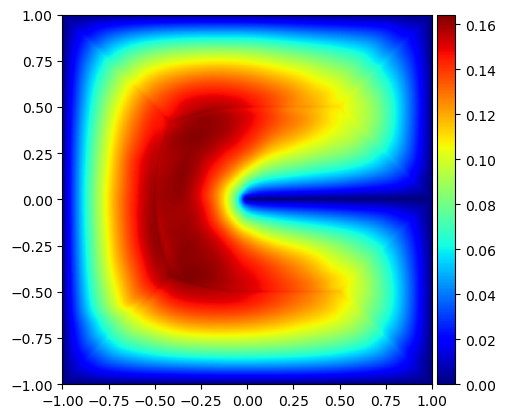

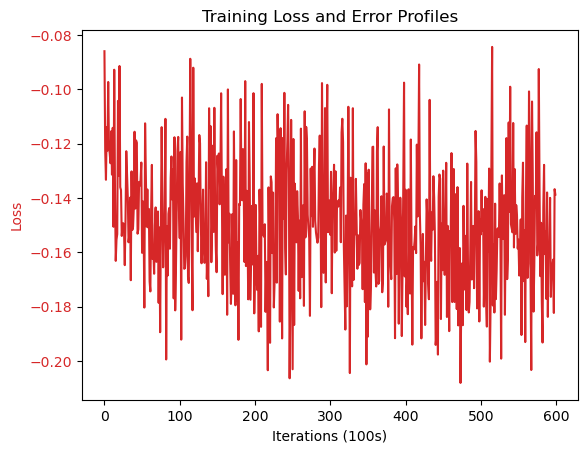

In [20]:
main_original(arch='drrnn_Tanh', epochs=60000)

### Feedforward NN, ReLU Activation

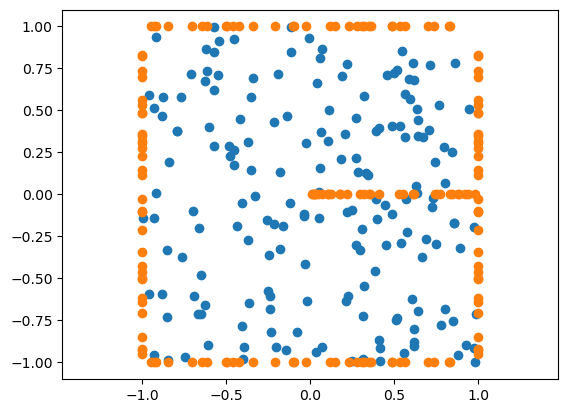

drfnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: 0.022367587313055992 loss_r: 0.022367587313055992
epoch: 100 loss: -0.10599173605442047 loss_r: -0.10599173605442047
epoch: 200 loss: -0.10522230714559555 loss_r: -0.10522230714559555
epoch: 300 loss: -0.11327574402093887 loss_r: -0.11327574402093887
epoch: 400 loss: -0.12087898701429367 loss_r: -0.12087898701429367
epoch: 500 loss: -0.10553694516420364 loss_r: -0.10553694516420364
epoch: 600 loss: -0.09972882270812988 loss_r: -0.09972882270812988
epoch: 700 loss: -0.0995037630200386 loss_r: -0.0995037630200386
epoch: 800 loss: -0.1212349385023117 loss_r: -0.1212349385023117
epoch: 900 loss: -0.10480174422264099 loss_r: -0.10480174422264099
epoch: 1000 loss: -0.10975180566310883 loss_r: -0.10975180566310883
epoch: 1100 loss: -0.1146521344780922 loss_r: -0.1146521344780922
epoch: 1200 loss: -0.11478723585605621 loss_r: -0.11478723585605621
epoch: 1300 loss: -0.10020574927330017 loss_r: -0.10020574927330017
epoch: 1400 loss: -0.10143961757421494 loss_r: -0.1014396175742149

epoch: 12100 loss: -0.10449214279651642 loss_r: -0.10449214279651642
epoch: 12200 loss: -0.10042618215084076 loss_r: -0.10042618215084076
epoch: 12300 loss: -0.10840769857168198 loss_r: -0.10840769857168198
epoch: 12400 loss: -0.10764691978693008 loss_r: -0.10764691978693008
epoch: 12500 loss: -0.11623695492744446 loss_r: -0.11623695492744446
epoch: 12600 loss: -0.11387334764003754 loss_r: -0.11387334764003754
epoch: 12700 loss: -0.09983770549297333 loss_r: -0.09983770549297333
epoch: 12800 loss: -0.113911934196949 loss_r: -0.113911934196949
epoch: 12900 loss: -0.11844510585069656 loss_r: -0.11844510585069656
epoch: 13000 loss: -0.11741205304861069 loss_r: -0.11741205304861069
epoch: 13100 loss: -0.12000065296888351 loss_r: -0.12000065296888351
epoch: 13200 loss: -0.1042068675160408 loss_r: -0.1042068675160408
epoch: 13300 loss: -0.09886233508586884 loss_r: -0.09886233508586884
epoch: 13400 loss: -0.10532072931528091 loss_r: -0.10532072931528091
epoch: 13500 loss: -0.12160709500312805 

epoch: 24100 loss: -0.11850635707378387 loss_r: -0.11850635707378387
epoch: 24200 loss: -0.12137678265571594 loss_r: -0.12137678265571594
epoch: 24300 loss: -0.1137407049536705 loss_r: -0.1137407049536705
epoch: 24400 loss: -0.10353641211986542 loss_r: -0.10353641211986542
epoch: 24500 loss: -0.11971524357795715 loss_r: -0.11971524357795715
epoch: 24600 loss: -0.10579755902290344 loss_r: -0.10579755902290344
epoch: 24700 loss: -0.1206439957022667 loss_r: -0.1206439957022667
epoch: 24800 loss: -0.11050986498594284 loss_r: -0.11050986498594284
epoch: 24900 loss: -0.12282496690750122 loss_r: -0.12282496690750122
epoch: 25000 loss: -0.12651894986629486 loss_r: -0.12651894986629486
epoch: 25100 loss: -0.1058986634016037 loss_r: -0.1058986634016037
epoch: 25200 loss: -0.10448348522186279 loss_r: -0.10448348522186279
epoch: 25300 loss: -0.10960834473371506 loss_r: -0.10960834473371506
epoch: 25400 loss: -0.10336245596408844 loss_r: -0.10336245596408844
epoch: 25500 loss: -0.10351517051458359 

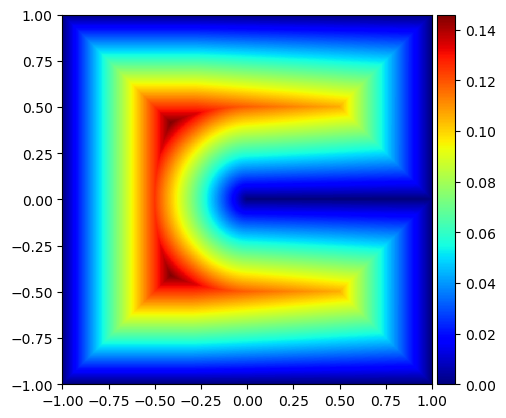

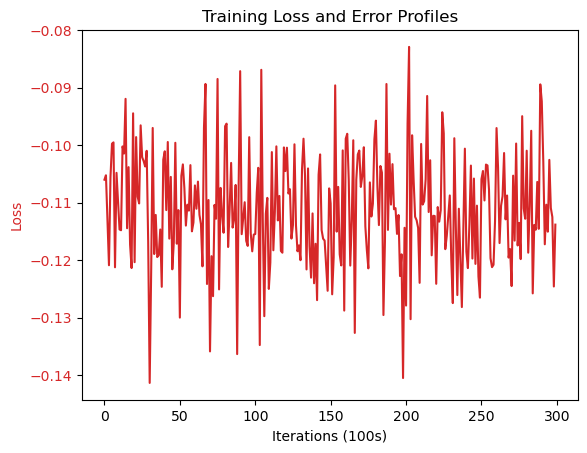

In [29]:
main_original(arch='drfnn_ReLU', epochs=30000)

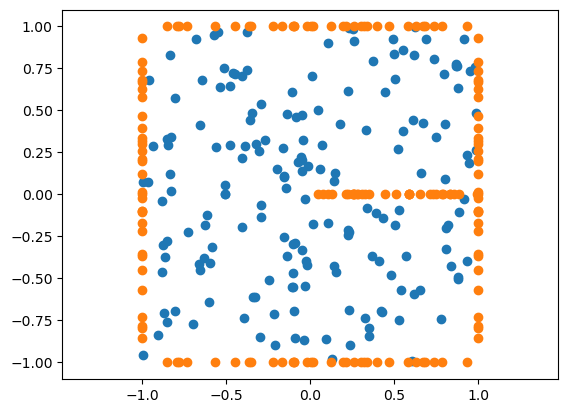

drfnn_ReLU


IntProgress(value=0, max=600)

epoch: 0 loss: 0.0015157972229644656 loss_r: 0.0015157972229644656
epoch: 100 loss: -0.12279330939054489 loss_r: -0.12279330939054489
epoch: 200 loss: -0.11527610570192337 loss_r: -0.11527610570192337
epoch: 300 loss: -0.10692425817251205 loss_r: -0.10692425817251205
epoch: 400 loss: -0.09389664232730865 loss_r: -0.09389664232730865
epoch: 500 loss: -0.09837853908538818 loss_r: -0.09837853908538818
epoch: 600 loss: -0.10572106391191483 loss_r: -0.10572106391191483
epoch: 700 loss: -0.12261075526475906 loss_r: -0.12261075526475906
epoch: 800 loss: -0.11052287369966507 loss_r: -0.11052287369966507
epoch: 900 loss: -0.11624263972043991 loss_r: -0.11624263972043991
epoch: 1000 loss: -0.12837818264961243 loss_r: -0.12837818264961243
epoch: 1100 loss: -0.11661792546510696 loss_r: -0.11661792546510696
epoch: 1200 loss: -0.10899169743061066 loss_r: -0.10899169743061066
epoch: 1300 loss: -0.08953895419836044 loss_r: -0.08953895419836044
epoch: 1400 loss: -0.09223606437444687 loss_r: -0.09223606

epoch: 12100 loss: -0.10986334085464478 loss_r: -0.10986334085464478
epoch: 12200 loss: -0.11523643881082535 loss_r: -0.11523643881082535
epoch: 12300 loss: -0.11232940107584 loss_r: -0.11232940107584
epoch: 12400 loss: -0.10395574569702148 loss_r: -0.10395574569702148
epoch: 12500 loss: -0.12219242751598358 loss_r: -0.12219242751598358
epoch: 12600 loss: -0.11428770422935486 loss_r: -0.11428770422935486
epoch: 12700 loss: -0.11269830912351608 loss_r: -0.11269830912351608
epoch: 12800 loss: -0.13038091361522675 loss_r: -0.13038091361522675
epoch: 12900 loss: -0.11718876659870148 loss_r: -0.11718876659870148
epoch: 13000 loss: -0.12030152231454849 loss_r: -0.12030152231454849
epoch: 13100 loss: -0.10176922380924225 loss_r: -0.10176922380924225
epoch: 13200 loss: -0.10653961449861526 loss_r: -0.10653961449861526
epoch: 13300 loss: -0.11120399087667465 loss_r: -0.11120399087667465
epoch: 13400 loss: -0.10605662316083908 loss_r: -0.10605662316083908
epoch: 13500 loss: -0.1067255511879921 l

epoch: 24100 loss: -0.11532755196094513 loss_r: -0.11532755196094513
epoch: 24200 loss: -0.12354499101638794 loss_r: -0.12354499101638794
epoch: 24300 loss: -0.1085483729839325 loss_r: -0.1085483729839325
epoch: 24400 loss: -0.10274329036474228 loss_r: -0.10274329036474228
epoch: 24500 loss: -0.12201391905546188 loss_r: -0.12201391905546188
epoch: 24600 loss: -0.11293157935142517 loss_r: -0.11293157935142517
epoch: 24700 loss: -0.10637416690587997 loss_r: -0.10637416690587997
epoch: 24800 loss: -0.10526476055383682 loss_r: -0.10526476055383682
epoch: 24900 loss: -0.12079622596502304 loss_r: -0.12079622596502304
epoch: 25000 loss: -0.1157807856798172 loss_r: -0.1157807856798172
epoch: 25100 loss: -0.11791112273931503 loss_r: -0.11791112273931503
epoch: 25200 loss: -0.11788325756788254 loss_r: -0.11788325756788254
epoch: 25300 loss: -0.12087676674127579 loss_r: -0.12087676674127579
epoch: 25400 loss: -0.12218489497900009 loss_r: -0.12218489497900009
epoch: 25500 loss: -0.0894160792231559

epoch: 36100 loss: -0.11374825239181519 loss_r: -0.11374825239181519
epoch: 36200 loss: -0.13032756745815277 loss_r: -0.13032756745815277
epoch: 36300 loss: -0.10523521900177002 loss_r: -0.10523521900177002
epoch: 36400 loss: -0.11743094772100449 loss_r: -0.11743094772100449
epoch: 36500 loss: -0.12063784152269363 loss_r: -0.12063784152269363
epoch: 36600 loss: -0.10454535484313965 loss_r: -0.10454535484313965
epoch: 36700 loss: -0.11212518066167831 loss_r: -0.11212518066167831
epoch: 36800 loss: -0.1289622038602829 loss_r: -0.1289622038602829
epoch: 36900 loss: -0.1084381714463234 loss_r: -0.1084381714463234
epoch: 37000 loss: -0.09863349050283432 loss_r: -0.09863349050283432
epoch: 37100 loss: -0.10992512851953506 loss_r: -0.10992512851953506
epoch: 37200 loss: -0.10836519300937653 loss_r: -0.10836519300937653
epoch: 37300 loss: -0.11697398871183395 loss_r: -0.11697398871183395
epoch: 37400 loss: -0.11589643359184265 loss_r: -0.11589643359184265
epoch: 37500 loss: -0.1130890846252441

epoch: 48100 loss: -0.11585937440395355 loss_r: -0.11585937440395355
epoch: 48200 loss: -0.08887799829244614 loss_r: -0.08887799829244614
epoch: 48300 loss: -0.09898389875888824 loss_r: -0.09898389875888824
epoch: 48400 loss: -0.10358396917581558 loss_r: -0.10358396917581558
epoch: 48500 loss: -0.09560242295265198 loss_r: -0.09560242295265198
epoch: 48600 loss: -0.10973353683948517 loss_r: -0.10973353683948517
epoch: 48700 loss: -0.10498656332492828 loss_r: -0.10498656332492828
epoch: 48800 loss: -0.11926347762346268 loss_r: -0.11926347762346268
epoch: 48900 loss: -0.12149988859891891 loss_r: -0.12149988859891891
epoch: 49000 loss: -0.11138476431369781 loss_r: -0.11138476431369781
epoch: 49100 loss: -0.10330182313919067 loss_r: -0.10330182313919067
epoch: 49200 loss: -0.1161058098077774 loss_r: -0.1161058098077774
epoch: 49300 loss: -0.10660876333713531 loss_r: -0.10660876333713531
epoch: 49400 loss: -0.09476292133331299 loss_r: -0.09476292133331299
epoch: 49500 loss: -0.11168553680181

torch.Size([1002001, 1]) torch.Size([1002001, 1])


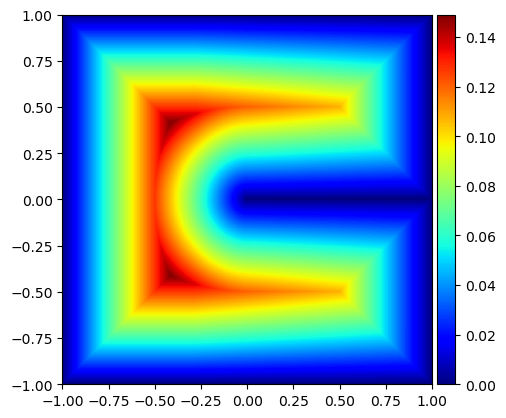

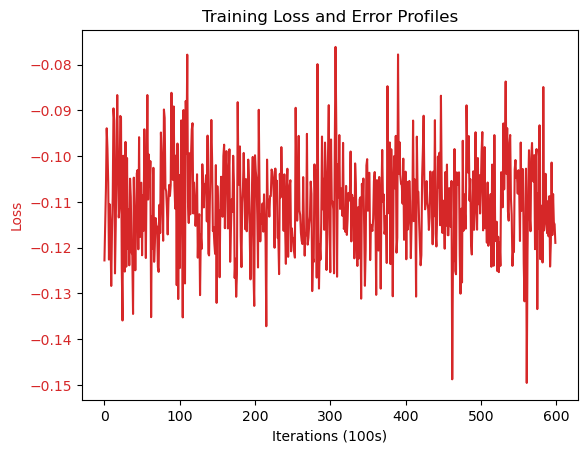

In [21]:
main_original(arch='drfnn_ReLU', epochs=60000)

### Feedforward NN, Tanh Activation

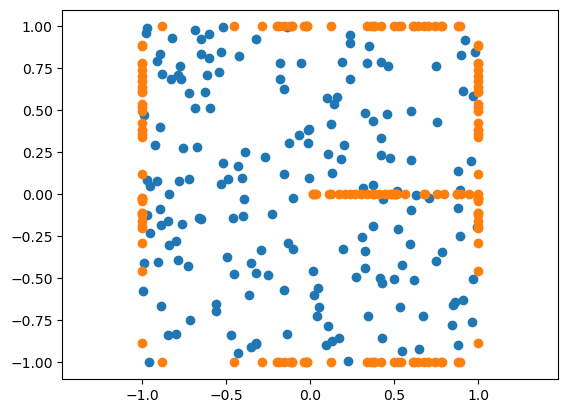

drfnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: 0.17354635894298553 loss_r: 0.17354635894298553
epoch: 100 loss: -0.1107829138636589 loss_r: -0.1107829138636589
epoch: 200 loss: -0.11517567187547684 loss_r: -0.11517567187547684
epoch: 300 loss: -0.10857374966144562 loss_r: -0.10857374966144562
epoch: 400 loss: -0.10669878870248795 loss_r: -0.10669878870248795
epoch: 500 loss: -0.0900871679186821 loss_r: -0.0900871679186821
epoch: 600 loss: -0.12540458142757416 loss_r: -0.12540458142757416
epoch: 700 loss: -0.13211993873119354 loss_r: -0.13211993873119354
epoch: 800 loss: -0.1491485834121704 loss_r: -0.1491485834121704
epoch: 900 loss: -0.11986980587244034 loss_r: -0.11986980587244034
epoch: 1000 loss: -0.13426680862903595 loss_r: -0.13426680862903595
epoch: 1100 loss: -0.12343324720859528 loss_r: -0.12343324720859528
epoch: 1200 loss: -0.1426362544298172 loss_r: -0.1426362544298172
epoch: 1300 loss: -0.1450323760509491 loss_r: -0.1450323760509491
epoch: 1400 loss: -0.1350557506084442 loss_r: -0.1350557506084442
epoch:

epoch: 12200 loss: -0.12570816278457642 loss_r: -0.12570816278457642
epoch: 12300 loss: -0.15234118700027466 loss_r: -0.15234118700027466
epoch: 12400 loss: -0.11717963963747025 loss_r: -0.11717963963747025
epoch: 12500 loss: -0.1393200010061264 loss_r: -0.1393200010061264
epoch: 12600 loss: -0.15935026109218597 loss_r: -0.15935026109218597
epoch: 12700 loss: -0.16678687930107117 loss_r: -0.16678687930107117
epoch: 12800 loss: -0.17103467881679535 loss_r: -0.17103467881679535
epoch: 12900 loss: -0.13654518127441406 loss_r: -0.13654518127441406
epoch: 13000 loss: -0.11103006452322006 loss_r: -0.11103006452322006
epoch: 13100 loss: -0.16964325308799744 loss_r: -0.16964325308799744
epoch: 13200 loss: -0.17850187420845032 loss_r: -0.17850187420845032
epoch: 13300 loss: -0.1672528088092804 loss_r: -0.1672528088092804
epoch: 13400 loss: -0.14951057732105255 loss_r: -0.14951057732105255
epoch: 13500 loss: -0.18281786143779755 loss_r: -0.18281786143779755
epoch: 13600 loss: -0.1531456708908081

epoch: 24200 loss: -0.17619703710079193 loss_r: -0.17619703710079193
epoch: 24300 loss: -0.16216786205768585 loss_r: -0.16216786205768585
epoch: 24400 loss: -0.20789694786071777 loss_r: -0.20789694786071777
epoch: 24500 loss: -0.18574707210063934 loss_r: -0.18574707210063934
epoch: 24600 loss: -0.14171761274337769 loss_r: -0.14171761274337769
epoch: 24700 loss: -0.14570491015911102 loss_r: -0.14570491015911102
epoch: 24800 loss: -0.17122678458690643 loss_r: -0.17122678458690643
epoch: 24900 loss: -0.15160930156707764 loss_r: -0.15160930156707764
epoch: 25000 loss: -0.16809916496276855 loss_r: -0.16809916496276855
epoch: 25100 loss: -0.1464807540178299 loss_r: -0.1464807540178299
epoch: 25200 loss: -0.11060533672571182 loss_r: -0.11060533672571182
epoch: 25300 loss: -0.168170765042305 loss_r: -0.168170765042305
epoch: 25400 loss: -0.17331276834011078 loss_r: -0.17331276834011078
epoch: 25500 loss: -0.16443367302417755 loss_r: -0.16443367302417755
epoch: 25600 loss: -0.17268115282058716 

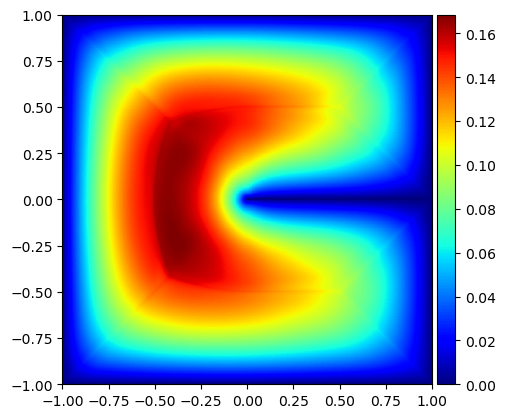

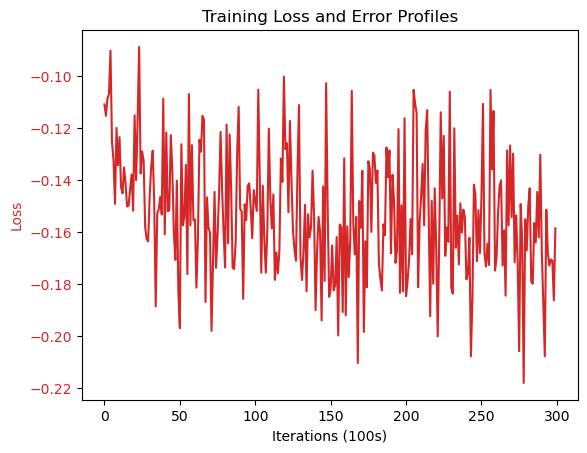

In [28]:
main_original(arch='drfnn_Tanh', epochs=30000)

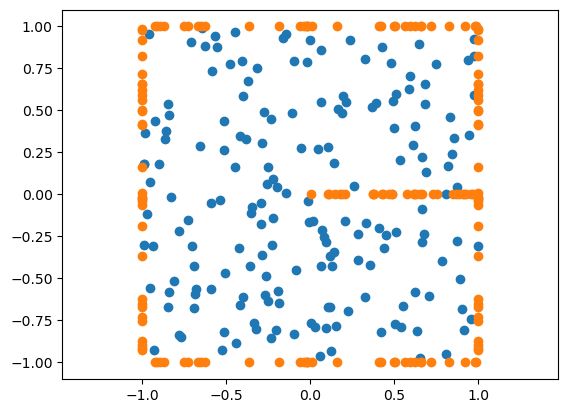

drfnn_Tanh


IntProgress(value=0, max=600)

epoch: 0 loss: 0.006644079461693764 loss_r: 0.006644079461693764
epoch: 100 loss: -0.0992002859711647 loss_r: -0.0992002859711647
epoch: 200 loss: -0.10729881376028061 loss_r: -0.10729881376028061
epoch: 300 loss: -0.12174930423498154 loss_r: -0.12174930423498154
epoch: 400 loss: -0.11779657006263733 loss_r: -0.11779657006263733
epoch: 500 loss: -0.13740108907222748 loss_r: -0.13740108907222748
epoch: 600 loss: -0.10391658544540405 loss_r: -0.10391658544540405
epoch: 700 loss: -0.1395556479692459 loss_r: -0.1395556479692459
epoch: 800 loss: -0.12828664481639862 loss_r: -0.12828664481639862
epoch: 900 loss: -0.13085119426250458 loss_r: -0.13085119426250458
epoch: 1000 loss: -0.12144745141267776 loss_r: -0.12144745141267776
epoch: 1100 loss: -0.15399841964244843 loss_r: -0.15399841964244843
epoch: 1200 loss: -0.1276288479566574 loss_r: -0.1276288479566574
epoch: 1300 loss: -0.14424806833267212 loss_r: -0.14424806833267212
epoch: 1400 loss: -0.13818860054016113 loss_r: -0.1381886005401611

epoch: 12200 loss: -0.13989661633968353 loss_r: -0.13989661633968353
epoch: 12300 loss: -0.10573852807283401 loss_r: -0.10573852807283401
epoch: 12400 loss: -0.11993087083101273 loss_r: -0.11993087083101273
epoch: 12500 loss: -0.17403452098369598 loss_r: -0.17403452098369598
epoch: 12600 loss: -0.14125701785087585 loss_r: -0.14125701785087585
epoch: 12700 loss: -0.15534070134162903 loss_r: -0.15534070134162903
epoch: 12800 loss: -0.1328219622373581 loss_r: -0.1328219622373581
epoch: 12900 loss: -0.17114131152629852 loss_r: -0.17114131152629852
epoch: 13000 loss: -0.18149548768997192 loss_r: -0.18149548768997192
epoch: 13100 loss: -0.1374191790819168 loss_r: -0.1374191790819168
epoch: 13200 loss: -0.16354165971279144 loss_r: -0.16354165971279144
epoch: 13300 loss: -0.13275237381458282 loss_r: -0.13275237381458282
epoch: 13400 loss: -0.12392517179250717 loss_r: -0.12392517179250717
epoch: 13500 loss: -0.14503002166748047 loss_r: -0.14503002166748047
epoch: 13600 loss: -0.1773422509431839

epoch: 24200 loss: -0.1417953073978424 loss_r: -0.1417953073978424
epoch: 24300 loss: -0.1799146682024002 loss_r: -0.1799146682024002
epoch: 24400 loss: -0.14561037719249725 loss_r: -0.14561037719249725
epoch: 24500 loss: -0.1361517459154129 loss_r: -0.1361517459154129
epoch: 24600 loss: -0.12675951421260834 loss_r: -0.12675951421260834
epoch: 24700 loss: -0.1492476612329483 loss_r: -0.1492476612329483
epoch: 24800 loss: -0.17967818677425385 loss_r: -0.17967818677425385
epoch: 24900 loss: -0.14988718926906586 loss_r: -0.14988718926906586
epoch: 25000 loss: -0.13703669607639313 loss_r: -0.13703669607639313
epoch: 25100 loss: -0.15809296071529388 loss_r: -0.15809296071529388
epoch: 25200 loss: -0.1927257627248764 loss_r: -0.1927257627248764
epoch: 25300 loss: -0.1191183403134346 loss_r: -0.1191183403134346
epoch: 25400 loss: -0.14749884605407715 loss_r: -0.14749884605407715
epoch: 25500 loss: -0.14543260633945465 loss_r: -0.14543260633945465
epoch: 25600 loss: -0.14270274341106415 loss_r

epoch: 36200 loss: -0.16456574201583862 loss_r: -0.16456574201583862
epoch: 36300 loss: -0.15651774406433105 loss_r: -0.15651774406433105
epoch: 36400 loss: -0.1819392293691635 loss_r: -0.1819392293691635
epoch: 36500 loss: -0.15001080930233002 loss_r: -0.15001080930233002
epoch: 36600 loss: -0.12060816586017609 loss_r: -0.12060816586017609
epoch: 36700 loss: -0.17275848984718323 loss_r: -0.17275848984718323
epoch: 36800 loss: -0.16478286683559418 loss_r: -0.16478286683559418
epoch: 36900 loss: -0.19287413358688354 loss_r: -0.19287413358688354
epoch: 37000 loss: -0.15924163162708282 loss_r: -0.15924163162708282
epoch: 37100 loss: -0.17797084152698517 loss_r: -0.17797084152698517
epoch: 37200 loss: -0.09555041044950485 loss_r: -0.09555041044950485
epoch: 37300 loss: -0.13700896501541138 loss_r: -0.13700896501541138
epoch: 37400 loss: -0.11281460523605347 loss_r: -0.11281460523605347
epoch: 37500 loss: -0.19104868173599243 loss_r: -0.19104868173599243
epoch: 37600 loss: -0.12170168757438

epoch: 48200 loss: -0.16015899181365967 loss_r: -0.16015899181365967
epoch: 48300 loss: -0.13018353283405304 loss_r: -0.13018353283405304
epoch: 48400 loss: -0.1254427433013916 loss_r: -0.1254427433013916
epoch: 48500 loss: -0.15659087896347046 loss_r: -0.15659087896347046
epoch: 48600 loss: -0.1757679283618927 loss_r: -0.1757679283618927
epoch: 48700 loss: -0.14518003165721893 loss_r: -0.14518003165721893
epoch: 48800 loss: -0.1726825088262558 loss_r: -0.1726825088262558
epoch: 48900 loss: -0.1691446602344513 loss_r: -0.1691446602344513
epoch: 49000 loss: -0.139753520488739 loss_r: -0.139753520488739
epoch: 49100 loss: -0.14957639575004578 loss_r: -0.14957639575004578
epoch: 49200 loss: -0.1406536102294922 loss_r: -0.1406536102294922
epoch: 49300 loss: -0.13911984860897064 loss_r: -0.13911984860897064
epoch: 49400 loss: -0.19055429100990295 loss_r: -0.19055429100990295
epoch: 49500 loss: -0.17521904408931732 loss_r: -0.17521904408931732
epoch: 49600 loss: -0.14055021107196808 loss_r: 

torch.Size([1002001, 1]) torch.Size([1002001, 1])


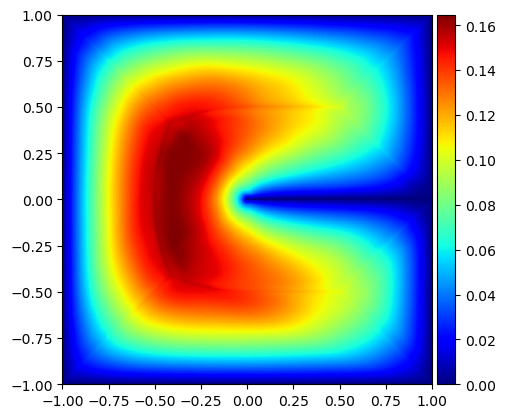

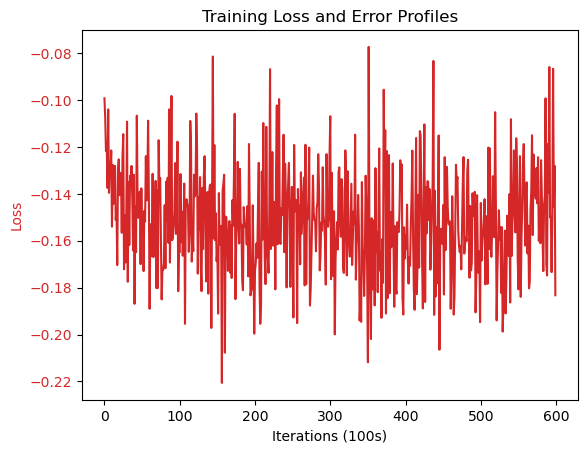

In [17]:
main_original(arch='drfnn_Tanh', epochs=60000)

--------------------------------------------------------------------------------------------------------------------------------